## 01 Exploratory Data Analysis
## Objetivo
Realizar un análisis exploratorio de los datos (EDA) para entender las características del dataset y detectar patrones, anomalías y relaciones entre las variables.



### **Organización de los Datos**
El conjunto de datos consta de dos tablas fundamentales. En primer lugar, contamos con la "Tabla de Transacciones", que ofrece información detallada sobre cada transacción realizada. En segundo lugar, encontramos la "Tabla de Identidad", la cual proporciona datos cruciales relacionados con la conexión de red, incluyendo información como la dirección IP, proveedor de servicios de Internet (ISP), el uso de proxy, entre otros.

Esta estructura dual del conjunto de datos permite una comprensión integral de las transacciones al incorporar tanto los detalles transaccionales como la identidad digital asociada, enriqueciendo así el análisis y la interpretación de la información.

In [1]:
## Librerías
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
from scipy import stats

In [2]:

def reduce_mem_usage(df, verbose=True):
    """
    Reduce el uso de memoria de un DataFrame de pandas cambiando los tipos de datos de las columnas numéricas
    a tipos más eficientes sin perder información.

    Parameters:
    df (pd.DataFrame): El DataFrame a optimizar.
    verbose (bool): Si es True, imprime el uso de memoria antes y después de la optimización.

    Returns:
    pd.DataFrame: El DataFrame optimizado.
    """
    # Obtener el uso inicial de memoria
    start_mem = df.memory_usage(deep=True).sum() / 1024**2

    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()

            # Optimización para tipos de datos enteros
            if pd.api.types.is_integer_dtype(df[col]):
                if c_min >= np.iinfo(np.int8).min and c_max <= np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min >= np.iinfo(np.int16).min and c_max <= np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min >= np.iinfo(np.int32).min and c_max <= np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min >= np.iinfo(np.int64).min and c_max <= np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)

            # Optimización para tipos de datos flotantes
            else:
                if c_min >= np.finfo(np.float16).min and c_max <= np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min >= np.finfo(np.float32).min and c_max <= np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    # Obtener el uso final de memoria
    end_mem = df.memory_usage(deep=True).sum() / 1024**2
    if verbose:
        print(f'Mem. usage decreased to {end_mem:.2f} Mb ({100 * (start_mem - end_mem) / start_mem:.1f}% reduction)')

    return df









In [3]:
## Importamos las librerias a usar
from google.colab import drive
drive.mount('/content/drive')
data_dir = '/content/drive/MyDrive/cursos-analisis-datos/data-science/proyecto/propuestas/propuesta1/ieee-fraud-detection'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
## directorio de los datasets
#data_dir = '../data/raw/ieee-fraud-detection'
## Lista de los archivos descargados
!ls -lh {data_dir}

total 1.3G
drwx------ 2 root root 4.0K Jun 22 14:48 processed
-rw------- 1 root root 5.8M Dec 12  2019 sample_submission.csv
-rw------- 1 root root  25M Dec 12  2019 test_identity.csv
-rw------- 1 root root 585M Dec 12  2019 test_transaction.csv
-rw------- 1 root root  26M Dec 12  2019 train_identity.csv
-rw------- 1 root root 652M Dec 12  2019 train_transaction.csv


In [5]:

files = ['train_transaction.csv', 'train_identity.csv', 'test_transaction.csv', 'test_identity.csv']

for file in files:
    file_path = os.path.join(data_dir, file)
    with open(file_path, 'r') as f:
        line_count = sum(1 for line in f)
    print(f'{file} tiene {line_count} líneas')


train_transaction.csv tiene 590541 líneas
train_identity.csv tiene 144234 líneas
test_transaction.csv tiene 506692 líneas
test_identity.csv tiene 141908 líneas


**Observación:**

Los datos de entrenamientos son más de un millon de registro, por lo tanto se toma una fracción de los registro de entrenamiento para este trabajo para facilitar el análisis y el entrenamiento del modelo.


### **Características Categóricas - Tabla Identity**

Las variables en esta tabla incluyen información de identidad, abarcando detalles de la conexión de red (IP, ISP, Proxy, etc.) y la firma digital (UA/navegador/sistema operativo/versión, etc.) asociada con las transacciones. Estos datos son recopilados por el sistema de protección contra fraudes de Vesta y socios de seguridad digital. (Los nombres de los campos están enmascarados y no se proporcionará un diccionario emparejado por razones de privacidad y acuerdo contractual).

- DeviceType
- DeviceInfo
- id_12 - id_38

Se realiza una fusión de ambas tablas para construir un único marco de datos. Además, procederemos a seleccionar una porción específica de este marco de datos, ya que, en esta primera fase del análisis, no es necesario utilizar todos los registros. Al final, emplearemos la totalidad de los datos.

### Selección de Porción del Dataset con Muestreo Estratificado

Para seleccionar una porción representativa de un dataset grande para entrenamiento sin introducir sesgo, se utiliza el muestreo aleatorio estratificado. Este método asegura que la proporción de clases en la muestra sea la misma que en el conjunto de datos original, lo cual es crucial para problemas de clasificación con clases desbalanceadas.


In [6]:

## Cargamos los dataset de train_transaction y train_identity
df_transaction_train = pd.read_csv(data_dir + '/train_transaction.csv')
df_identity_train = pd.read_csv(data_dir + '/train_identity.csv')
## Reducimos los tamaños de los dataset cambiando los tipos de los datos de las columnas
df_transaction_train = reduce_mem_usage(df_transaction_train)
df_identity_train = reduce_mem_usage(df_identity_train)

Mem. usage decreased to 867.89 Mb (58.7% reduction)
Mem. usage decreased to 138.38 Mb (12.2% reduction)


In [7]:


# Combinar los datasets
dataset = pd.merge(df_transaction_train, df_identity_train, on='TransactionID', how='left')
df_train = dataset
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Columns: 434 entries, TransactionID to DeviceInfo
dtypes: float16(354), float32(45), int16(1), int32(2), int8(1), object(31)
memory usage: 646.0+ MB


### Dimensiones del dataset

In [8]:
df_train.shape

(590540, 434)

## **Consideraciones Iniciales**
En la fase inicial de nuestro análisis, nos enfrentamos a una abrumadora cantidad de columnas. Con el objetivo de simplificar y focalizarnos en esta etapa inicial, buscaremos reducir el conjunto de columnas al máximo posible.

### Características Iniciales para el Análisis de Primera Etapa
1. **TransactionDT:** Representa un delta de tiempo desde un punto de referencia.
2. **TransactionAMT:** Indica la cantidad en USD para el pago de la transacción.
3. **ProductCD:** Código del producto.
4. **addr:** Dirección.
5. **dist:** Distancia.
6. **P_ and (R__):** Dominio de correo electrónico del comprador y del destinatario.
7. **deviceType**
8. **DeviceInfo**

Las siguientes características no se incluirán en esta fase inicial:
- **C1-C14:** Recuento, como la cantidad de direcciones asociadas a la tarjeta de pago, entre otros. El significado real está enmascarado.
- **D1-D15:** Timedelta, como los días entre la transacción anterior, etc.
- **M1-M9:** Coincidencias, como los nombres en la tarjeta y la dirección, etc.
- **Vxxx:** Características ricas desarrolladas por Vesta, que incluyen ranking, conteo y relaciones con otras entidades.

id_12 - id_38


Por lo tanto tenemos 11 columnas de propiedades y 59054 registros

### Tipos de datos y resumen estadísticos

In [9]:
import pandas as pd

# Suponiendo que ya tienes cargado tu dataset en 'df_train'

# Identificar tipos de datos
data_types = df_train.drop('isFraud',axis=1).dtypes

# Filtrar y contar variables numéricas y categóricas
num_vars = data_types[data_types != 'object']  # Variables numéricas
cat_vars = data_types[data_types == 'object']  # Variables categóricas

# Obtener nombres de las variables
num_vars_names = num_vars.index.tolist()
cat_vars_names = cat_vars.index.tolist()

# Mostrar resultados
print(f"Número de variables numéricas: {num_vars.shape[0]}")
print(f"Nombres de variables numéricas: {num_vars_names}")
print()
print(f"Número de variables categóricas: {cat_vars.shape[0]}")
print(f"Nombres de variables categóricas: {cat_vars_names}")


Número de variables numéricas: 402
Nombres de variables numéricas: ['TransactionID', 'TransactionDT', 'TransactionAmt', 'card1', 'card2', 'card3', 'card5', 'addr1', 'addr2', 'dist1', 'dist2', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V50', 'V51', 'V52', 'V53', 'V54', 'V55', 'V56', 'V57', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V65', 'V66', 'V67', 'V68', 'V69', 'V70', 'V71', 'V72', 'V73', 'V74', 'V75', 'V76', 'V77', 'V78', 'V79', 'V80', 'V81', 'V82', 'V83', 'V84', 'V85', 'V86', 'V87', 'V88', 'V89', 'V90', 'V

In [10]:
for columna in cat_vars_names :
    print(f"Columna: {columna}, el número de variables es: {df_train[columna].nunique()}")

Columna: ProductCD, el número de variables es: 5
Columna: card4, el número de variables es: 4
Columna: card6, el número de variables es: 4
Columna: P_emaildomain, el número de variables es: 59
Columna: R_emaildomain, el número de variables es: 60
Columna: M1, el número de variables es: 2
Columna: M2, el número de variables es: 2
Columna: M3, el número de variables es: 2
Columna: M4, el número de variables es: 3
Columna: M5, el número de variables es: 2
Columna: M6, el número de variables es: 2
Columna: M7, el número de variables es: 2
Columna: M8, el número de variables es: 2
Columna: M9, el número de variables es: 2
Columna: id_12, el número de variables es: 2
Columna: id_15, el número de variables es: 3
Columna: id_16, el número de variables es: 2
Columna: id_23, el número de variables es: 3
Columna: id_27, el número de variables es: 2
Columna: id_28, el número de variables es: 2
Columna: id_29, el número de variables es: 2
Columna: id_30, el número de variables es: 75
Columna: id_31

## Análisis de valores nulos

### Identificación de valores nulos

### Porcentaje de valores nulos

In [11]:
# Calcula el porcentaje de valores nulos para cada columna
null_percentages = (df_train.isnull().sum() / len(dataset)) * 100

# Define los rangos para los valores nulos
ranges = [
    (0, 10),
    (10, 20),
    (20, 30),
    (30, 40),
    (40, 50),
    (50, 60),
    (60, 70),
    (70, 80),
    (80, 90),
    (90, 100)
]

# Agrupa las columnas en los rangos definidosa
grouped_columns = {f'{r[0]}-{r[1]}%': [] for r in ranges}

for column, percentage in null_percentages.items():
    for r in ranges:
        if r[0] <= percentage < r[1]:
            grouped_columns[f'{r[0]}-{r[1]}%'].append(column)

# Imprime los resultados
for range_, columns in grouped_columns.items():
    if columns:
        print(f'Rango de valores nulos: {range_}')
        print(f'Columnas: {columns}')
        print()

Rango de valores nulos: 0-10%
Columnas: ['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'V95', 'V96', 'V97', 'V98', 'V99', 'V100', 'V101', 'V102', 'V103', 'V104', 'V105', 'V106', 'V107', 'V108', 'V109', 'V110', 'V111', 'V112', 'V113', 'V114', 'V115', 'V116', 'V117', 'V118', 'V119', 'V120', 'V121', 'V122', 'V123', 'V124', 'V125', 'V126', 'V127', 'V128', 'V129', 'V130', 'V131', 'V132', 'V133', 'V134', 'V135', 'V136', 'V137', 'V279', 'V280', 'V281', 'V282', 'V283', 'V284', 'V285', 'V286', 'V287', 'V288', 'V289', 'V290', 'V291', 'V292', 'V293', 'V294', 'V295', 'V296', 'V297', 'V298', 'V299', 'V300', 'V301', 'V302', 'V303', 'V304', 'V305', 'V306', 'V307', 'V308', 'V309', 'V310', 'V311', 'V312', 'V313', 'V314', 'V315', 'V316', 'V317', 'V318', 'V319', 'V320', 'V321']

Rango de valores nulos: 10-20%
Columnas: ['addr1',

In [12]:


# Suponiendo que ya tienes cargado tu dataset en 'df_train'

# Crear una nueva DataFrame booleano indicando valores nulos
df_nulls = df_train.sample(frac=0.1).isnull()

# Calcular la correlación entre los valores nulos
corr_nulls = df_nulls.corr()

# Obtener triángulo superior de la matriz de correlación (sin la diagonal principal)
upper_triangle = corr_nulls.where(np.triu(np.ones(corr_nulls.shape), k=1).astype(bool))

# Definir umbral de correlación
threshold = 0.5

# Filtrar pares de variables con correlación mayor que el umbral
high_corr_pairs = upper_triangle[upper_triangle.abs() > threshold].stack().reset_index()
high_corr_pairs.columns = ['Variable 1', 'Variable 2', 'Correlación']

# Mostrar los pares de variables con alta correlación ordenados por la correlación
high_corr_pairs_sorted = high_corr_pairs.sort_values(by='Correlación', ascending=False)
print(high_corr_pairs_sorted)


      Variable 1 Variable 2  Correlación
0          card3      card4     1.000000
29313       V184       V194     1.000000
29316       V184       V197     1.000000
29317       V184       V198     1.000000
29319       V184       V200     1.000000
...          ...        ...          ...
16920        V74       V327    -0.940035
12628        V54       V325    -0.940035
16919        V74       V326    -0.940035
15034        V65       V322    -0.940035
12412        V53       V334    -0.940035

[40063 rows x 3 columns]




Las variables también muestran una alta correlación de datos nulos, reflejada en la gran cantidad de valores ausentes para cada variable, lo cual contribuye a un alto valor de correlación entre ellas.

### Valores Duplicados

In [13]:
df_train[df_train.duplicated(keep=False)].count().sum()

0

Debido a la baja presencia de valores duplicados, procederemos a eliminarlos del dataset.



## Análisis Univariado

### Columna Target 'isFraud'

Comenzamos el análisis focalizándonos en la columna "isFraud", ya que representa el resultado de nuestros predictores o características. Evaluamos la cantidad de registros y representaremos visualmente esta información mediante un gráfico de barras, con el propósito de ilustrar la cantidad de registros clasificados como fraude y aquellos que no lo son.

In [14]:
df_train['isFraud'].value_counts()

isFraud
0    569877
1     20663
Name: count, dtype: int64

<ipython-input-15-3b3dcc77bce0>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_fraude, x='isFraud', y='count', palette=['tab:blue', 'tab:red'], ax=ax)


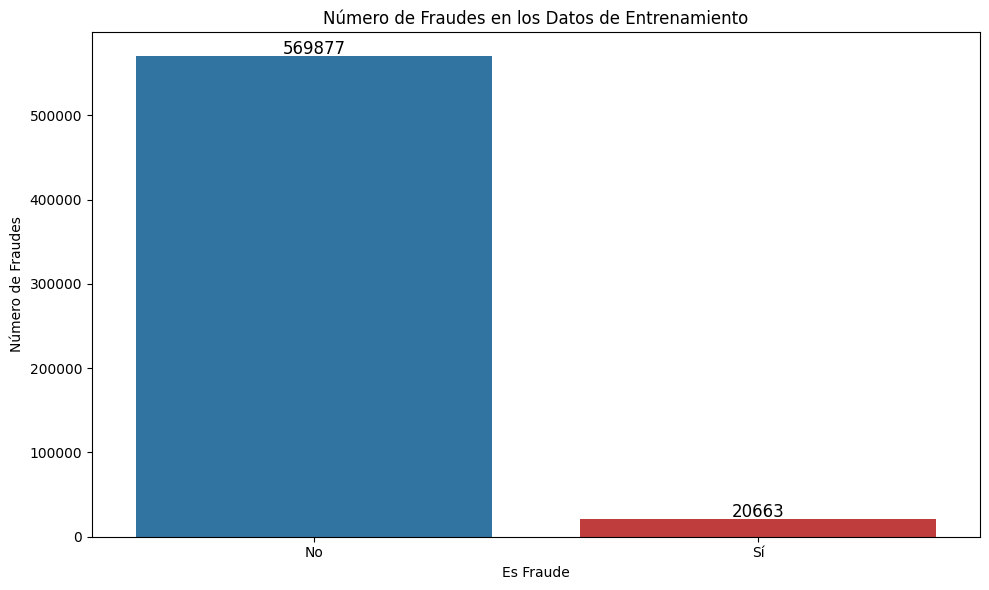

In [15]:
# Calcular los números de fraudes en los datos de entrenamiento
Numero_fraude = df_train.isFraud.value_counts()
df_fraude = pd.DataFrame(Numero_fraude).rename(index={0: 'No', 1: 'Sí'})
df_fraude.reset_index(inplace=True)
df_fraude.columns = ['isFraud', 'count']  # Renombrar columnas para usar en seaborn

# Crear la figura y el eje
fig, ax = plt.subplots(figsize=(10, 6))

# Crear el gráfico de barras
sns.barplot(data=df_fraude, x='isFraud', y='count', palette=['tab:blue', 'tab:red'], ax=ax)

# Etiquetas y título
ax.set_ylabel('Número de Fraudes')
ax.set_title('Número de Fraudes en los Datos de Entrenamiento')
ax.set_xlabel('Es Fraude')

# Añadir etiquetas a las barras
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=12, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.tight_layout()

# Guardar la figura
#plt.savefig(base_dir + 'balance_datos.png')

# Mostrar la figura
plt.show()


In [16]:


# Calcular los porcentajes de fraudes en los datos de entrenamiento
porcentaje_fraude = df_train['isFraud'].value_counts(normalize=True) * 100

# Crear un DataFrame con los porcentajes
df_porcentaje_fraude = pd.DataFrame(porcentaje_fraude)

# Renombrar las columnas
df_porcentaje_fraude.columns = ['Porcentaje']

# Restaurar los índices originales
df_porcentaje_fraude.reset_index(inplace=True)

# Renombrar las categorías
df_porcentaje_fraude['isFraud'] = df_porcentaje_fraude['isFraud'].map({0: 'No', 1: 'Sí'})

# Mostrar el DataFrame
df_porcentaje_fraude


,isFraud,Porcentaje
0,No,96.500999
1,Sí,3.499001


Obervación:
**Cantidad de registros por archivo**

| Es Fraude | N° de Registros |
| ------------ | ------------ |
| No| 96,45%|
| Sí| 3.54%|

Se destaca que la mayoría abrumadora de las transacciones se encuentran en la categoría no fraudulenta, mientras que solo una fracción mínima corresponde a casos de fraude. Este desbalance en los datos puede representar un desafío significativo para el proceso de aprendizaje automático, ya que los modelos pueden tener dificultades para identificar y aprender patrones en las clases minoritarias debido a su escasez relativa

### Análisis de las caracteterísticas

### Columna Importe del pago por transacción en USD (TransactionAmt)


Analizamos la asociación entre la columna "TransactionAmt", que representa los importes de cada transacción, y la columna de fraude. Este análisis incluye la evaluación de la distribución de los montos en relación con la presencia de fraudes.



In [17]:
df_train[['TransactionAmt']].describe().round(2)

,TransactionAmt
count,590540.00
mean,NaN
std,NaN
min,0.25
25%,43.31
50%,68.75
75%,125.00
max,31936.00


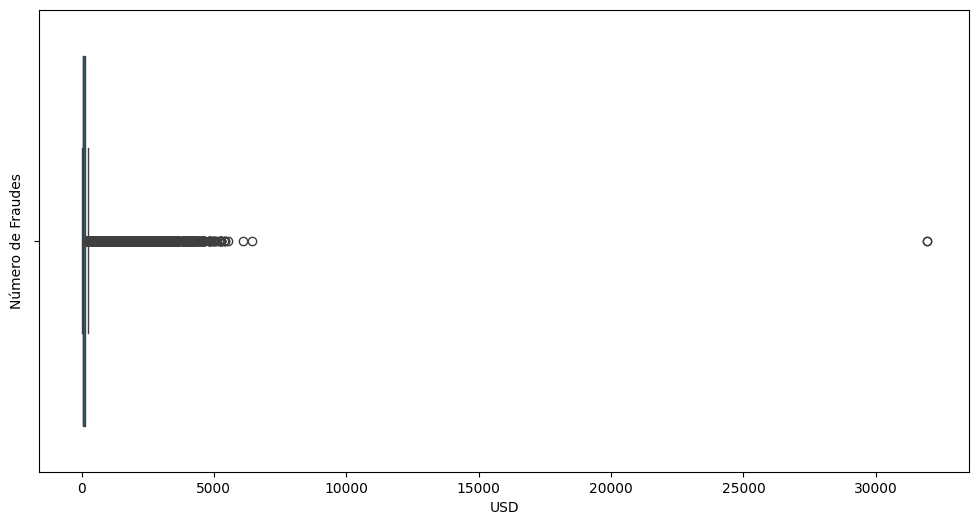

In [18]:
plt.figure(figsize=(12,6))
sns.boxplot(data=df_train, x='TransactionAmt')
plt.ylabel('Número de Fraudes')
plt.xlabel('USD')
#plt.savefig(base_dir + 'trabs_total_box_plot')
plt.show()

El valor medio de la variable 'TransactionAmt' es de 134.5, con una desviación estándar de 263.63. Además, el valor máximo está considerablemente alejado del tercer quartil del 75%  de los datos, lo que indica la presencia de valores atípicos en esta característica, en el gráfico de arriba se pued apreciar con mas detalle la exitencia de valores atípicos.

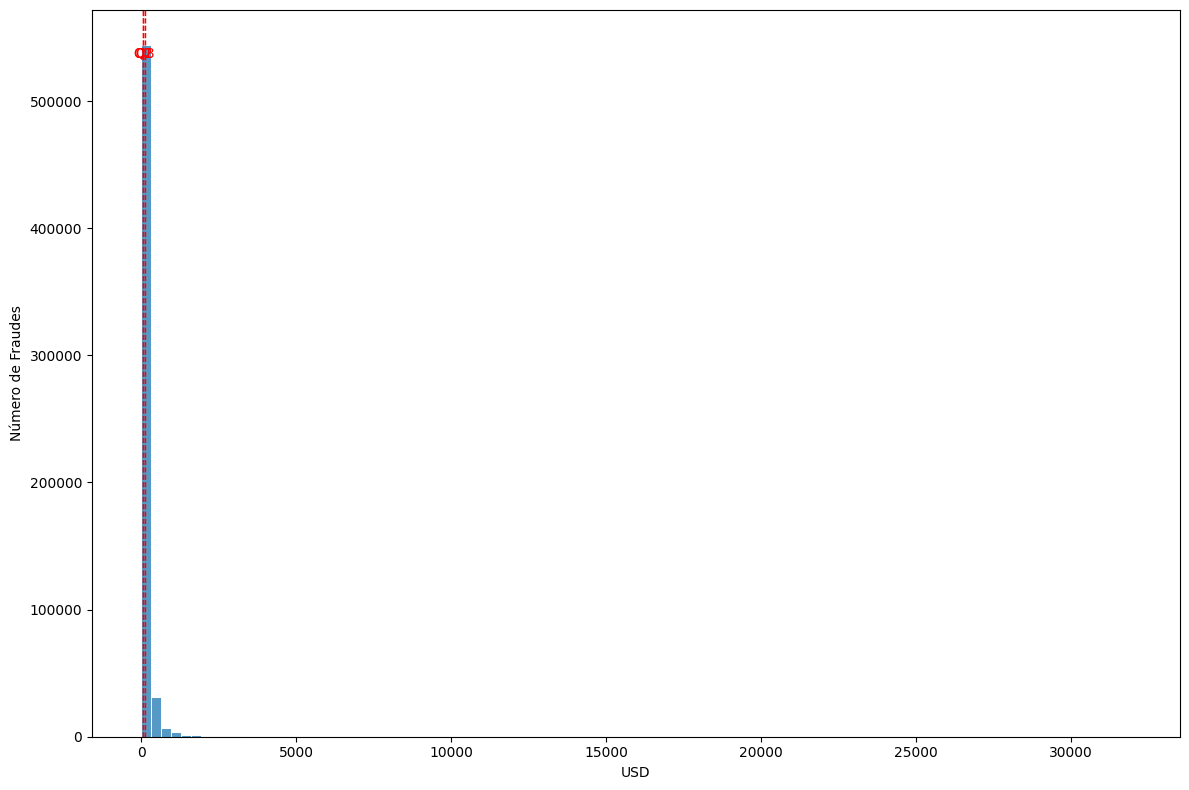

In [19]:
quartiles = np.percentile(df_train['TransactionAmt'], [25, 50, 75])
mean_value = df_train['TransactionAmt'].mean()

fig, axs = plt.subplots(tight_layout=True, figsize=(12, 8))

# Crear el histograma
sns.histplot(data=df_train, x='TransactionAmt', bins=100, color='tab:blue', edgecolor="white", linewidth=0.7, label='No', log_scale=False, ax=axs)

# Añadir líneas de los cuartiles
for q in quartiles:
    axs.axvline(q, color='red', linestyle='--', linewidth=1)

# Añadir línea de la media
axs.axvline(mean_value, color='green', linestyle='-', linewidth=1)

# Etiquetas y título
axs.set_ylabel('Número de Fraudes')
axs.set_xlabel('USD')

# Añadir leyenda para los cuartiles y la media
quartile_labels = ['Q1', 'Q2', 'Q3']
for i, q in enumerate(quartiles):
    axs.text(q, axs.get_ylim()[1] * 0.95, quartile_labels[i], color='red', ha='center', va='top')
axs.text(mean_value, axs.get_ylim()[1] * 0.95, 'Mean', color='green', ha='center', va='top')

plt.show()

#### Vemos ahora estos valores en escala logarítmicas

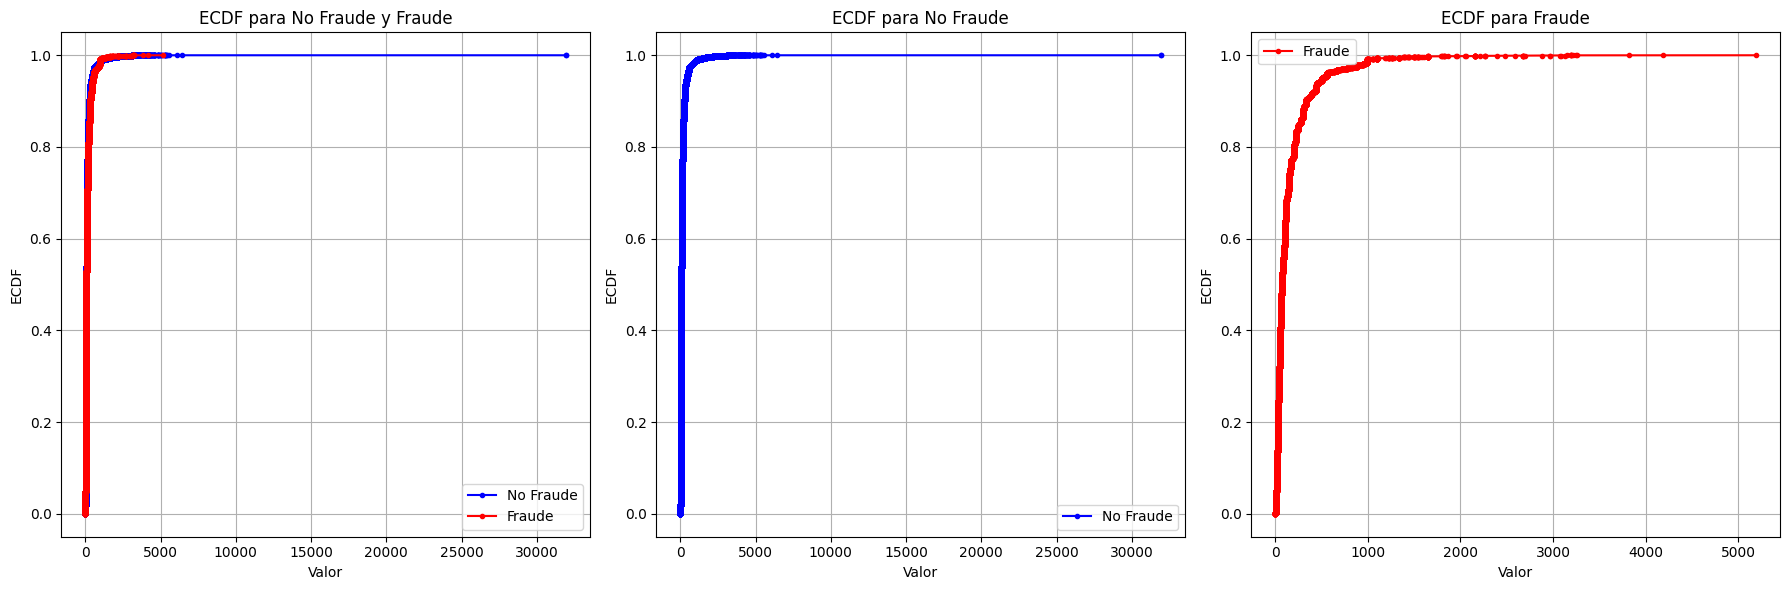

La función ECDF nos permite observar claramente las diferencias entre las distribuciones con y sin fraude. Se puede notar que la curva con fraude es más suave en comparación con la de no fraude, lo cual sugiere que esta diferencia podría ser una variable relevante para utilizar en el entrenamiento del modelo.

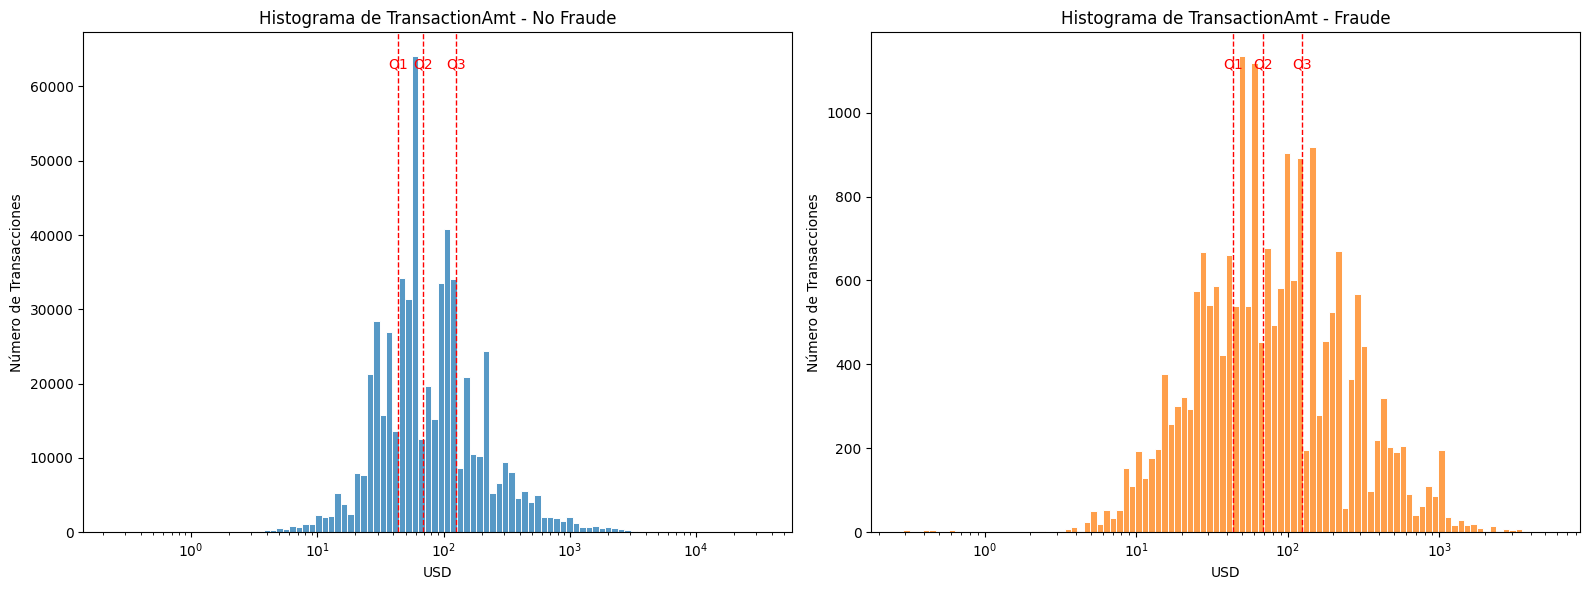

/usr/local/lib/python3.10/dist-packages/matplotlib/transforms.py:365: RuntimeWarning: invalid value encountered in scalar subtract
  return points[1, 0] - points[0, 0]


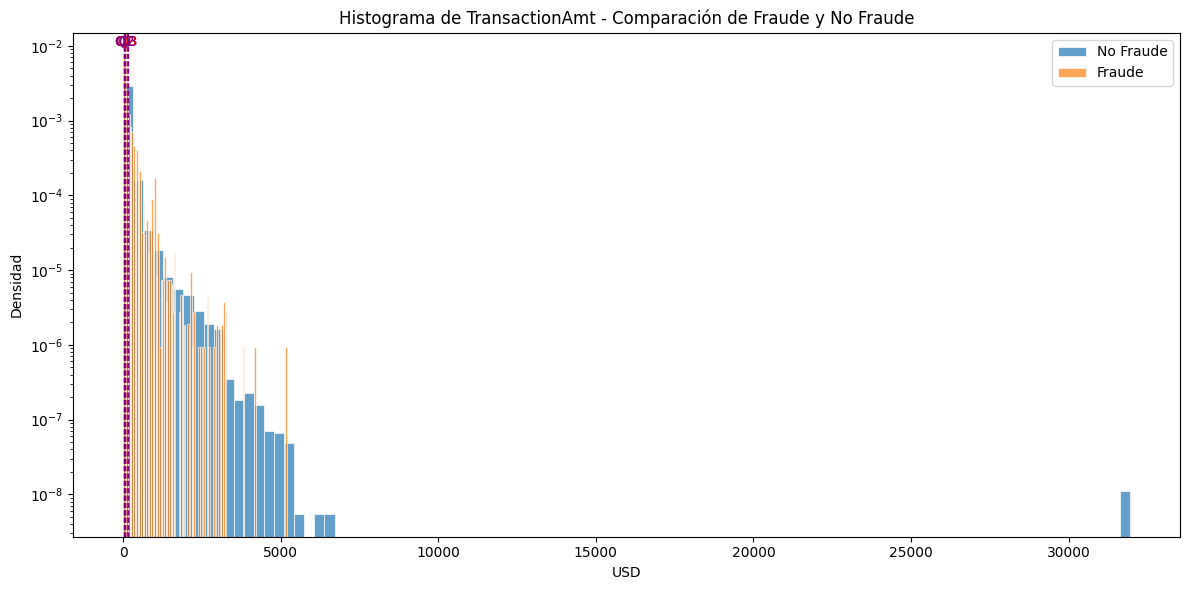

In [97]:
stats_by_fraud = df_train.groupby('isFraud')['TransactionAmt'].describe().round(2)

# Mostrar el resultado
print(stats_by_fraud)

            count  mean  std   min    25%   50%    75%      max
isFraud                                                        
0        569877.0   NaN  NaN  0.25  43.97  68.5  120.0  31936.0
1         20663.0   inf  inf  0.29  35.03  75.0  161.0   5192.0


Observación:

En la representación gráfica de la distribución y en la tabla de estadísticos asociada a la columna "TransactionAmt", se destacan las siguientes observaciones:

- Se evidencia una notable disparidad de la mediana (Q2) con el valor medio de los valores de TransactionAmt.
- El valor medio casi coincide con el los 75% de  valores (Q3) esto señale la gran dispersión de los valores.


La comparación entre el límite superior del rango intercuartil y el valor máximo revela discrepancias significativas en órdenes de magnitud, indicando la presencia de datos atípicos.

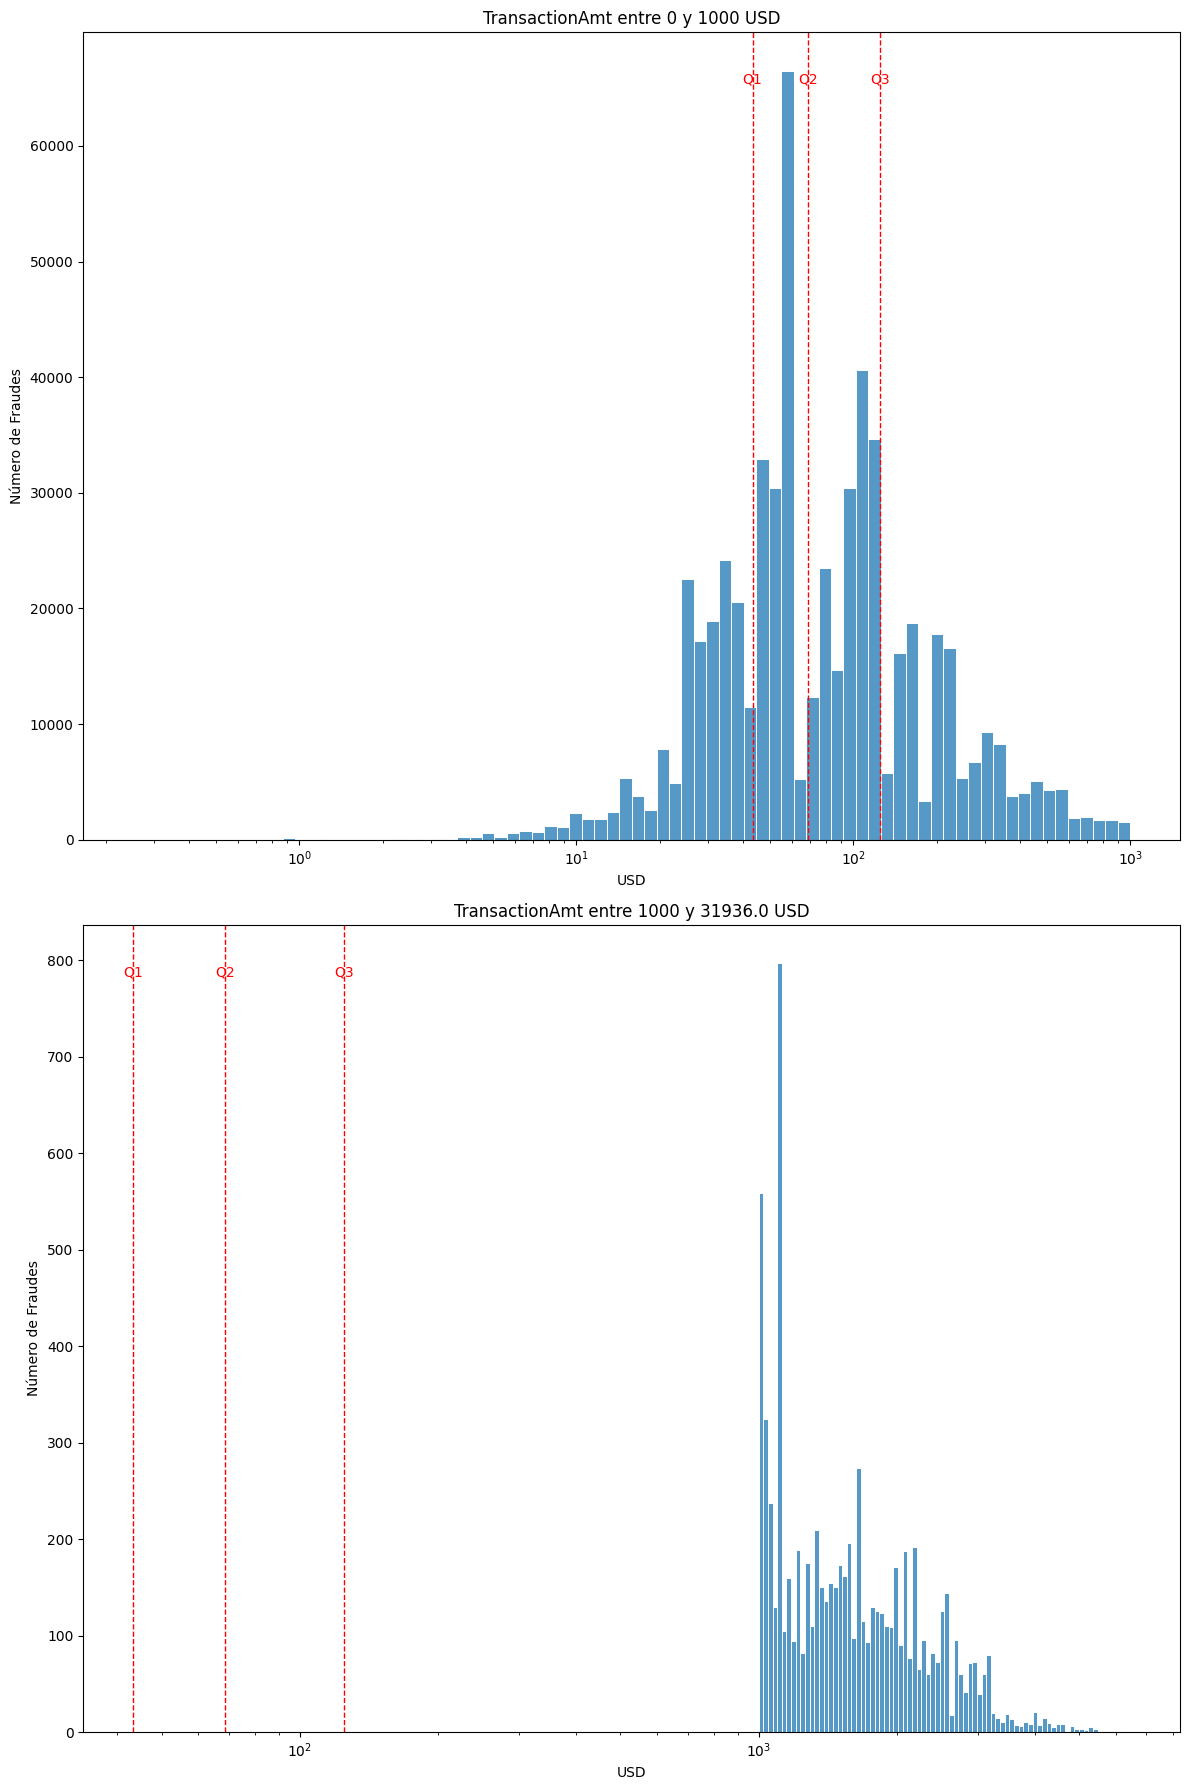

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# Definir los rangos para 'TransactionAmt'
ranges = [(0, 1000),(1000, df_train['TransactionAmt'].max())]

# Crear la figura y los subplots
fig, axs = plt.subplots(nrows=2, tight_layout=True, figsize=(12, 18))

# Generar el histograma para cada rango
for ax, (min_val, max_val) in zip(axs, ranges):
    subset = df_train[(df_train['TransactionAmt'] >= min_val) & (df_train['TransactionAmt'] < max_val)]
    sns.histplot(data=subset, x='TransactionAmt', bins=80, color='tab:blue', edgecolor="white", linewidth=0.7, label='No', ax=ax, log_scale=True)
    ax.set_title(f'TransactionAmt entre {min_val} y {max_val} USD')
    ax.set_ylabel('Número de Fraudes')
    ax.set_xlabel('USD')
    # Añadir líneas de los cuartiles
    for q in quartiles:
        ax.axvline(q, color='red', linestyle='--', linewidth=1)

    # Añadir línea de la media
    ax.axvline(mean_value, color='green', linestyle='-', linewidth=1)

    # Etiquetas y título
    ax.set_ylabel('Número de Fraudes')
    ax.set_xlabel('USD')

    # Añadir leyenda para los cuartiles y la media
    quartile_labels = ['Q1', 'Q2', 'Q3']
    for i, q in enumerate(quartiles):
        ax.text(q, ax.get_ylim()[1] * 0.95, quartile_labels[i], color='red', ha='center', va='top')
    ax.text(mean_value, ax.get_ylim()[1] * 0.95, 'Mean', color='green', ha='center', va='top')



plt.show()


Separamos el histograma en dos rangos de valores: uno de 0 a 1000 y otro de 1000 hasta el valor máximo. Al observar cada rango, notamos que presentan distribuciones diferentes, lo cual indica una posible segmentación en esta característica.

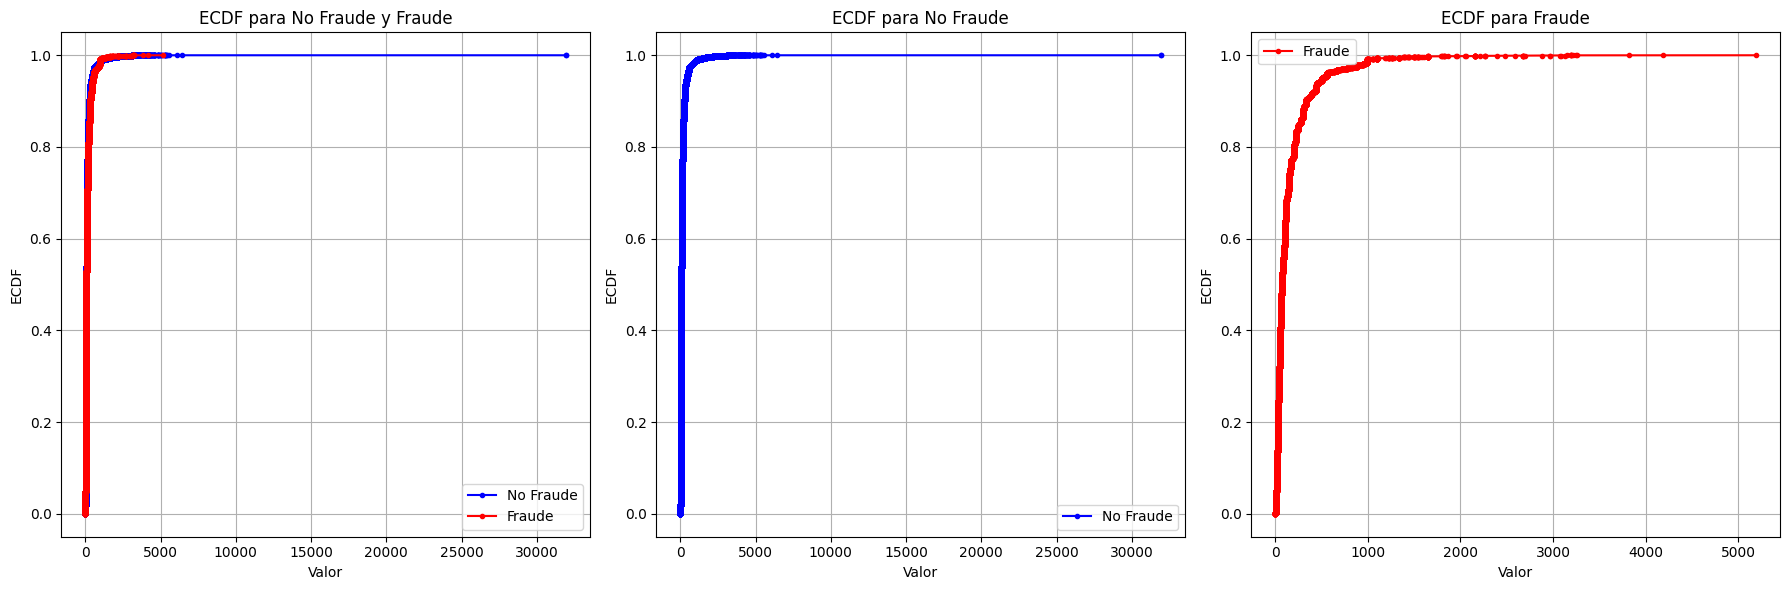

In [98]:
def ecdf(data):
    x = np.sort(data)
    y = np.arange(1, len(data)+1) / len(data)
    return x, y
# Calcular ECDF para no fraude y fraude
x_ecdf_no_fraude, y_ecdf_no_fraude = ecdf(df_train[df_train['isFraud'] == 0]['TransactionAmt'])
x_ecdf_fraude, y_ecdf_fraude =ecdf(df_train[df_train['isFraud'] == 1]['TransactionAmt'])


# Graficar ECDF
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Subplot 1: ECDF para No Fraude y Fraude juntos
axs[0].plot(x_ecdf_no_fraude, y_ecdf_no_fraude, marker='.', linestyle='-', color='blue', label='No Fraude')
axs[0].plot(x_ecdf_fraude, y_ecdf_fraude, marker='.', linestyle='-', color='red', label='Fraude')
axs[0].set_xlabel('Valor')
axs[0].set_ylabel('ECDF')
axs[0].set_title('ECDF para No Fraude y Fraude')
axs[0].legend()
axs[0].grid(True)

# Subplot 2: ECDF solo para No Fraude
axs[1].plot(x_ecdf_no_fraude, y_ecdf_no_fraude, marker='.', linestyle='-', color='blue', label='No Fraude')
axs[1].set_xlabel('Valor')
axs[1].set_ylabel('ECDF')
axs[1].set_title('ECDF para No Fraude')
axs[1].legend()
axs[1].grid(True)

# Subplot 3: ECDF solo para Fraude
axs[2].plot(x_ecdf_fraude, y_ecdf_fraude, marker='.', linestyle='-', color='red', label='Fraude')
axs[2].set_xlabel('Valor')
axs[2].set_ylabel('ECDF')
axs[2].set_title('ECDF para Fraude')
axs[2].legend()
axs[2].grid(True)

plt.tight_layout()
plt.show()

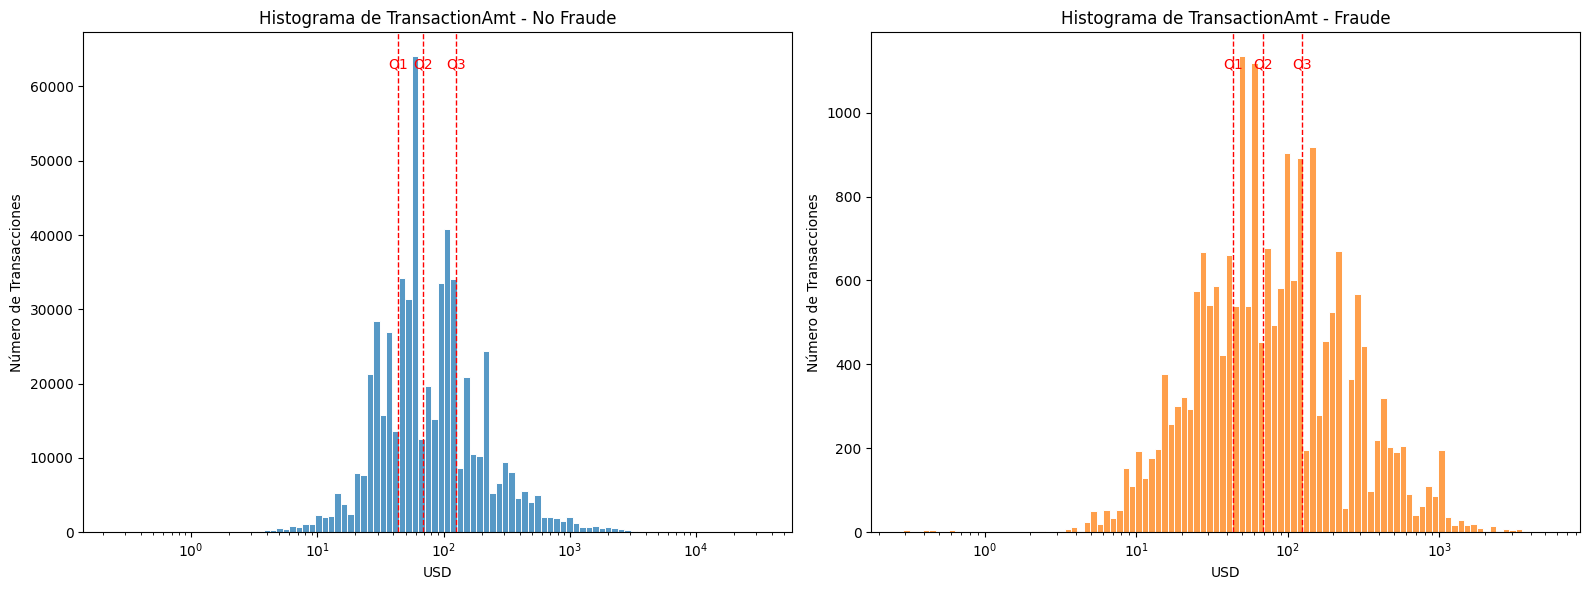

In [99]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Calcular cuartiles y media
quartiles = np.percentile(df_train['TransactionAmt'], [25, 50, 75])
mean_value = df_train['TransactionAmt'].mean()

# Crear la figura y los ejes para ambos histogramas
fig, axs = plt.subplots(1, 2, tight_layout=True, figsize=(16, 6))

# Histograma para transacciones no fraudulentas
sns.histplot(data=df_train[df_train['isFraud'] == 0], x='TransactionAmt', bins=100, color='tab:blue', edgecolor="white", linewidth=0.7, label='No Fraude', log_scale=True, ax=axs[0])

# Añadir líneas de los cuartiles para no fraude
for q in quartiles:
    axs[0].axvline(q, color='red', linestyle='--', linewidth=1)

# Añadir línea de la media para no fraude
axs[0].axvline(mean_value, color='green', linestyle='-', linewidth=1)

# Etiquetas y título para el primer histograma
axs[0].set_ylabel('Número de Transacciones')
axs[0].set_xlabel('USD')
axs[0].set_title('Histograma de TransactionAmt - No Fraude')

# Añadir leyenda para los cuartiles y la media en el primer histograma
quartile_labels = ['Q1', 'Q2', 'Q3']
for i, q in enumerate(quartiles):
    axs[0].text(q, axs[0].get_ylim()[1] * 0.95, quartile_labels[i], color='red', ha='center', va='top')
axs[0].text(mean_value, axs[0].get_ylim()[1] * 0.95, 'Mean', color='green', ha='center', va='top')

# Histograma para transacciones fraudulentas
sns.histplot(data=df_train[df_train['isFraud'] == 1], x='TransactionAmt', bins=100, color='tab:orange', edgecolor="white", linewidth=0.7, label='Fraude', log_scale=True, ax=axs[1])

# Añadir líneas de los cuartiles para fraude
for q in quartiles:
    axs[1].axvline(q, color='red', linestyle='--', linewidth=1)

# Añadir línea de la media para fraude
axs[1].axvline(mean_value, color='green', linestyle='-', linewidth=1)

# Etiquetas y título para el segundo histograma
axs[1].set_ylabel('Número de Transacciones')
axs[1].set_xlabel('USD')
axs[1].set_title('Histograma de TransactionAmt - Fraude')

# Añadir leyenda para los cuartiles y la media en el segundo histograma
for i, q in enumerate(quartiles):
    axs[1].text(q, axs[1].get_ylim()[1] * 0.95, quartile_labels[i], color='red', ha='center', va='top')
axs[1].text(mean_value, axs[1].get_ylim()[1] * 0.95, 'Mean', color='green', ha='center', va='top')

plt.tight_layout()
plt.show()


/usr/local/lib/python3.10/dist-packages/matplotlib/transforms.py:365: RuntimeWarning: invalid value encountered in scalar subtract
  return points[1, 0] - points[0, 0]


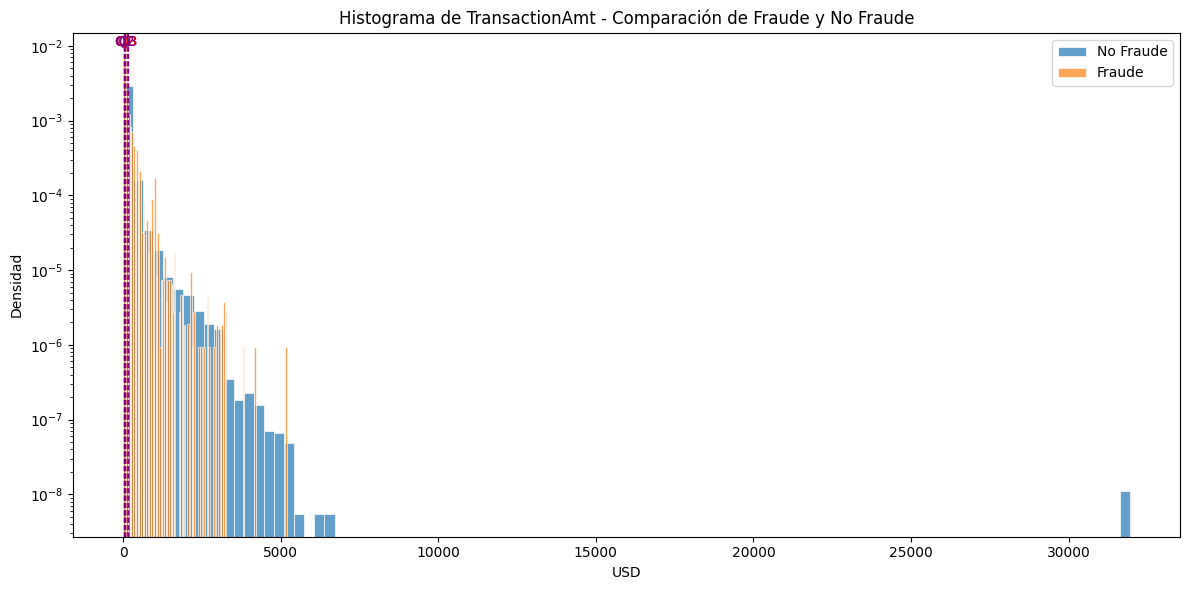

In [100]:

# Definir los datos
df_no_fraude = df_train[df_train['isFraud'] == 0]['TransactionAmt']
df_fraude = df_train[df_train['isFraud'] == 1]['TransactionAmt']

# Calcular cuartiles y media
quartiles_no_fraude = np.percentile(df_no_fraude, [25, 50, 75])
mean_value_no_fraude = df_no_fraude.mean()

quartiles_fraude = np.percentile(df_fraude, [25, 50, 75])
mean_value_fraude = df_fraude.mean()

# Crear la figura y los ejes
fig, ax = plt.subplots(figsize=(12, 6))

# Histograma para transacciones no fraudulentas (normalizado)
plt.hist(df_no_fraude, bins=100, color='tab:blue', edgecolor="white", linewidth=0.7, label='No Fraude', log=True, density=True, alpha=0.7)

# Añadir líneas de los cuartiles para no fraude
for q in quartiles_no_fraude:
    ax.axvline(q, color='red', linestyle='--', linewidth=1)

# Añadir línea de la media para no fraude
ax.axvline(mean_value_no_fraude, color='green', linestyle='-', linewidth=1)

# Histograma para transacciones fraudulentas (normalizado)
plt.hist(df_fraude, bins=100, color='tab:orange', edgecolor="white", linewidth=0.7, label='Fraude', log=True, density=True, alpha=0.7)

# Añadir líneas de los cuartiles para fraude
for q in quartiles_fraude:
    ax.axvline(q, color='purple', linestyle='--', linewidth=1)

# Añadir línea de la media para fraude
ax.axvline(mean_value_fraude, color='black', linestyle='-', linewidth=1)

# Etiquetas y título
ax.set_ylabel('Densidad')
ax.set_xlabel('USD')
ax.set_title('Histograma de TransactionAmt - Comparación de Fraude y No Fraude')

# Añadir leyenda para los cuartiles y la media
quartile_labels = ['Q1', 'Q2', 'Q3']
ax.text(mean_value_no_fraude, ax.get_ylim()[1] * 0.95, 'Mean No Fraude', color='green', ha='center', va='top')
ax.text(mean_value_fraude, ax.get_ylim()[1] * 0.95, 'Mean Fraude', color='black', ha='center', va='top')
for i, q in enumerate(quartiles_no_fraude):
    ax.text(q, ax.get_ylim()[1] * 0.95, quartile_labels[i], color='red', ha='center', va='top')
for i, q in enumerate(quartiles_fraude):
    ax.text(q, ax.get_ylim()[1] * 0.95, quartile_labels[i], color='purple', ha='center', va='top')

# Mostrar la leyenda y ajustar el gráfico
ax.legend()
plt.tight_layout()
plt.show()


In [101]:
stats_by_fraud = df_train.groupby('isFraud')['TransactionAmt'].describe().round(2)

# Mostrar el resultado
print(stats_by_fraud)

            count  mean  std   min    25%   50%    75%      max
isFraud                                                        
0        569877.0   NaN  NaN  0.25  43.97  68.5  120.0  31936.0
1         20663.0   inf  inf  0.29  35.03  75.0  161.0   5192.0


- El valor máximo de transacciones fraudulentas es de 5192. Por lo tanto, procederemos a filtrar nuestro DataFrame utilizando este umbral como punto de corte.

In [102]:
df_train = df_train[df_train['TransactionAmt'] < 5192]

### Separación de los datos por rango de la columna de (TransactionAmt)

In [103]:

# Calcular los cuartiles y el IQR
Q1 = np.percentile(df_train['TransactionAmt'], 25)
Q3 = np.percentile(df_train['TransactionAmt'], 75)
IQR = Q3 - Q1

# Definir los umbrales para valores atípicos
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Función para clasificar los valores en rangos
def classify_transaction_amt(value):
    if value < lower_bound:
        return 'Muy bajo'
    elif lower_bound <= value < Q1:
        return 'Bajo'
    elif Q1 <= value < Q3:
        return 'Medio'
    elif Q3 <= value < upper_bound:
        return 'Alto'
    else:
        return 'Muy alto'

# Aplicar la función de clasificación a la columna
df_train['TransactionAmt_Range'] = df_train['TransactionAmt'].apply(classify_transaction_amt)

# Mostrar algunos resultados
print(df_train['TransactionAmt_Range'].value_counts())


TransactionAmt_Range
Medio       294745
Bajo        147626
Alto         81688
Muy alto     66466
Name: count, dtype: int64


<ipython-input-103-98b1e8134461>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['TransactionAmt_Range'] = df_train['TransactionAmt'].apply(classify_transaction_amt)


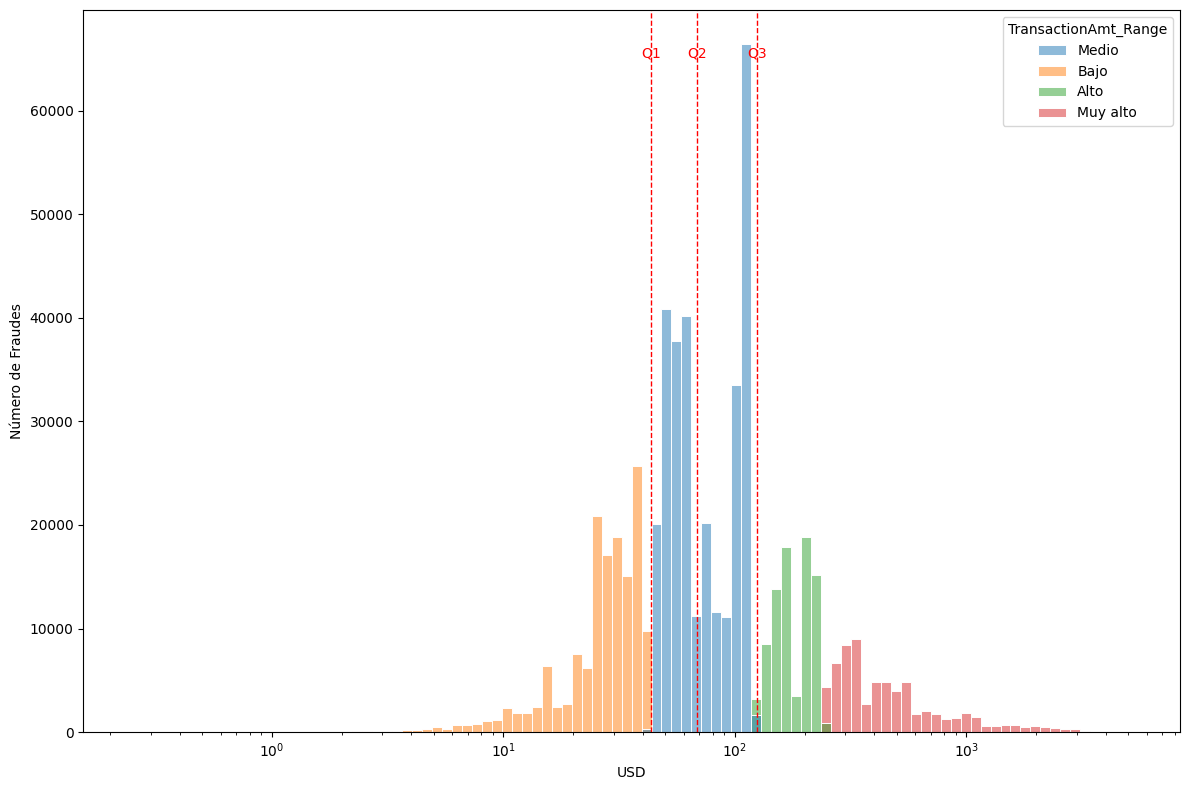

In [104]:
quartiles = np.percentile(df_train['TransactionAmt'], [25, 50, 75])
mean_value = df_train['TransactionAmt'].mean()

fig, axs = plt.subplots(tight_layout=True, figsize=(12, 8))

# Crear el histograma
sns.histplot(data=df_train, x='TransactionAmt', bins=100, color='tab:blue',
             edgecolor="white", linewidth=0.7, label='No', log_scale=True, ax=axs,hue='TransactionAmt_Range')

# Añadir líneas de los cuartiles
for q in quartiles:
    axs.axvline(q, color='red', linestyle='--', linewidth=1)

# Añadir línea de la media
axs.axvline(mean_value, color='green', linestyle='-', linewidth=1)

# Etiquetas y título
axs.set_ylabel('Número de Fraudes')
axs.set_xlabel('USD')

# Añadir leyenda para los cuartiles y la media
quartile_labels = ['Q1', 'Q2', 'Q3']
for i, q in enumerate(quartiles):
    axs.text(q, axs.get_ylim()[1] * 0.95, quartile_labels[i], color='red', ha='center', va='top')
axs.text(mean_value, axs.get_ylim()[1] * 0.95, 'Mean', color='green', ha='center', va='top')

plt.show()

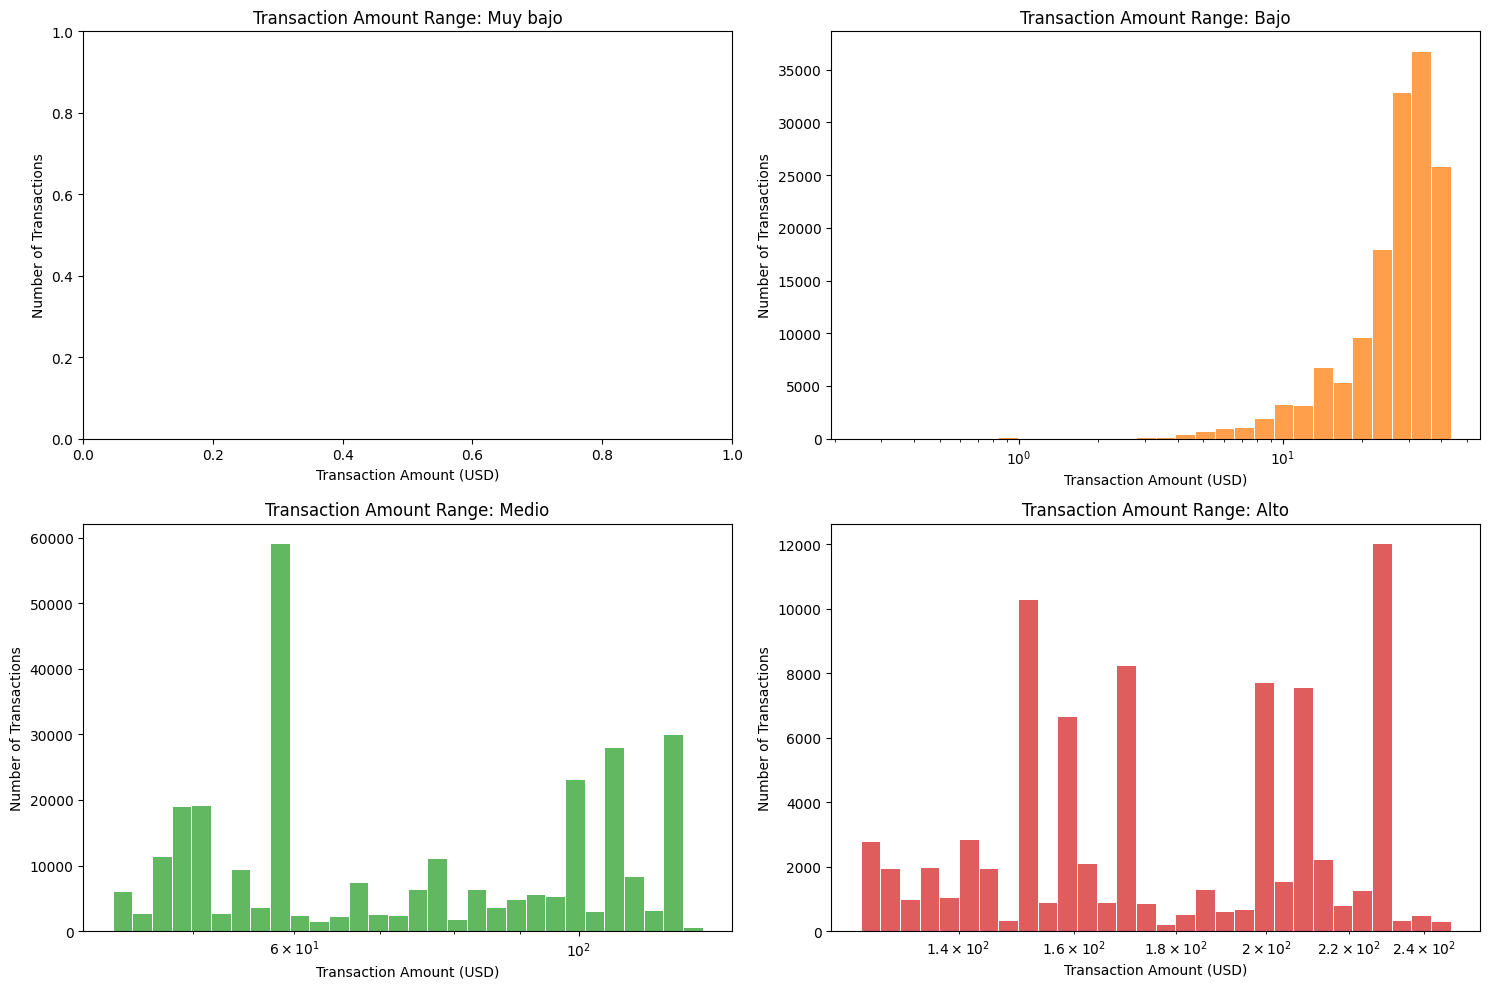

In [105]:

# Crear subplots para cada rango de valor
fig, axs = plt.subplots(2, 2, figsize=(15, 10), sharey=False, tight_layout=True)

# Definir los nombres de los rangos y los colores correspondientes
range_labels = ['Muy bajo', 'Bajo', 'Medio', 'Alto']
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']

# Iterar sobre los subplots y los rangos
for i, ax in enumerate(axs.flatten()):
    range_label = range_labels[i]
    color = colors[i]

    # Filtrar datos para el rango actual
    subset_data = df_train[df_train['TransactionAmt_Range'] == range_label]

    # Verificar si hay datos en el subset
    if not subset_data.empty:
        # Calcular el número de transacciones en el rango actual
        num_transactions = len(subset_data)

        # Crear el histograma para el rango actual
        sns.histplot(data=subset_data, x='TransactionAmt', bins=30, color=color,
                     edgecolor="white", linewidth=0.7, log_scale=True, ax=ax)

        ax.set_ylim(bottom=0)

    # Etiquetas y título para cada subplot
    ax.set_title(f'Transaction Amount Range: {range_label}')
    ax.set_xlabel('Transaction Amount (USD)')
    ax.set_ylabel('Number of Transactions')

# Ajustar el espacio entre subplots y mostrar la figura
plt.tight_layout()
plt.show()

- Cada valor en la columna TransactionAmt se clasifica en uno de los rangos definidos (Muy bajo, Bajo, Medio, Alto, Muy alto) según los cuartiles y los límites de valores atípicos. Se crea una nueva columna llamada TransactionAmt_Range en el DataFrame, que contiene el rango correspondiente para cada valor de TransactionAmt.
- No hay datos clasificados en la categoría "Muy Bajo".
- La columna TransactionAmt será reemplazada por TransactionAmt_Range ya que ambas contienen esencialmente la misma información. La columna TransactionAmt tiene valores que varían considerablemente entre diferentes rangos, lo cual dificultaría la normalización y complicaría el entrenamiento de los modelos. Por lo tanto, TransactionAmt será eliminada y reemplazada por TransactionAmt_Range que tiene las categorías separadas por rangos.

### Columna Intervalo de tiempo (**TransactionDT**)

**TransactionDT**: timedelta desde una fecha de referencia dada (no es una marca de tiempo real).
- "El primer valor de TransactionDT es 86400, que corresponde al número de segundos en un día (60 * 60 * 24 = 86400), por lo que creo que la unidad es segundos. Usando esto, sabemos que los datos abarcan 6 meses, ya que el valor máximo es 15811131, lo que correspondería al día 183."

In [106]:
df_train[['TransactionDT']].describe().round(2)

,TransactionDT
count,590525.00
mean,7372274.11
std,4617246.66
min,86400.00
25%,3027002.00
50%,7306489.00
75%,11246665.00
max,15811131.00


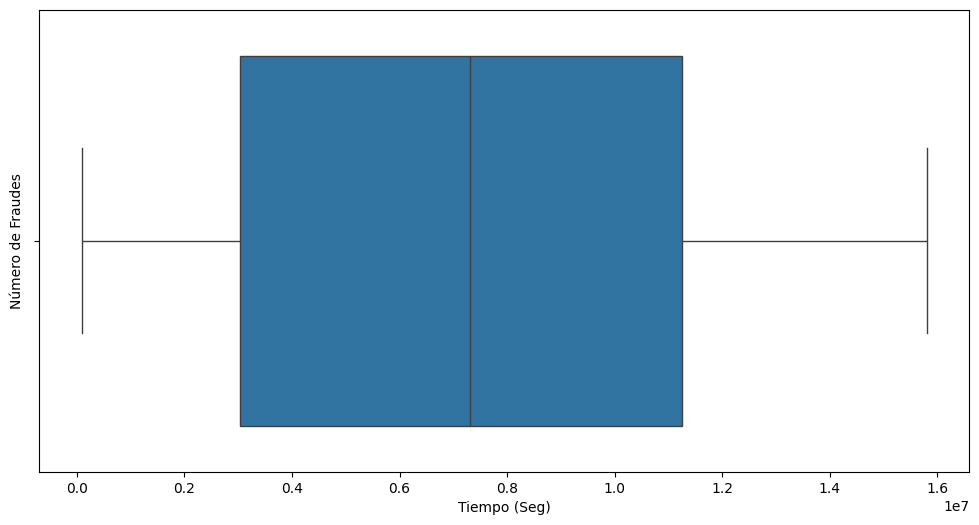

In [107]:
plt.figure(figsize=(12,6))
sns.boxplot(data=df_train, x='TransactionDT')
plt.ylabel('Número de Fraudes')
plt.xlabel('Tiempo (Seg)')
#plt.savefig(base_dir + 'trabs_total_box_plot')
plt.show()

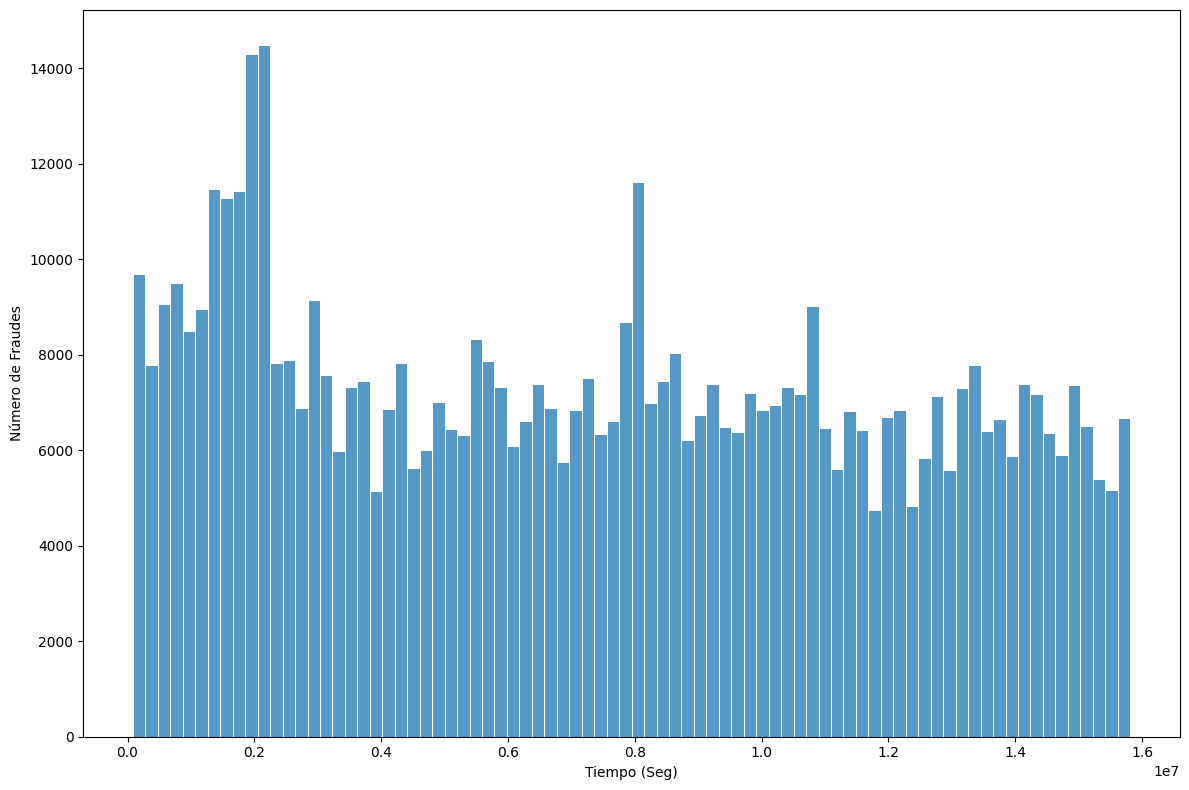

In [108]:
fig, axs = plt.subplots(tight_layout=True, figsize=(12, 8))

sns.histplot(data=df_train, x='TransactionDT', bins=80, color='tab:blue', edgecolor="white", linewidth=0.7, label='No')
axs.set_ylabel('Número de Fraudes')
axs.set_xlabel('Tiempo (Seg)')

plt.show()


**Observación:** La distribución de los tiempo de transacción es casi uniforme, aunuque se observa que algunos tiempo de transacciones son más frecuente que otros.

### Columna ProductCD

**ProductCD**: código de producto, el producto para cada transacción.
- "El producto no necesariamente tiene que ser un 'producto' real (como un artículo para agregar al carrito de compras). Podría ser cualquier tipo de servicio."

In [109]:
df_train['ProductCD'].unique()

array(['W', 'H', 'C', 'S', 'R'], dtype=object)

<ipython-input-110-933dbb527927>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=productCD_percent.index, y=productCD_percent.values, palette='tab10', ax=axes[1])


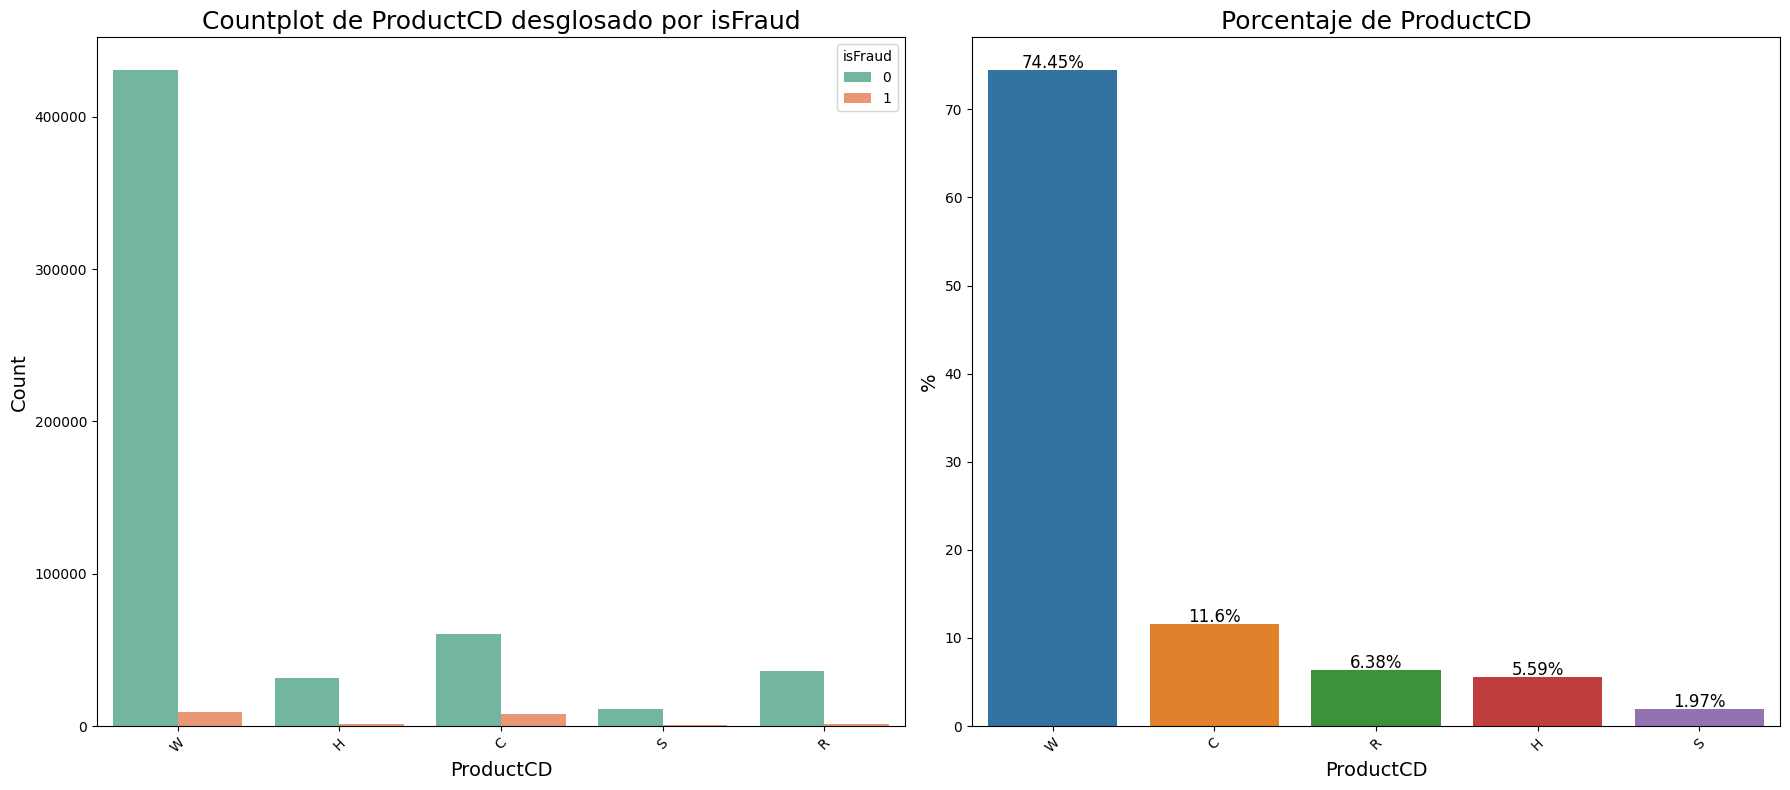

In [110]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Supongamos que ya tienes df_train y 'ProductCD' está presente en tus datos

# Calcular el porcentaje de cada categoría en ProductCD
productCD_percent = round((df_train['ProductCD'].value_counts() / len(df_train['ProductCD'])) * 100, 2)

# Crear la figura y los ejes para los gráficos
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Graficar el countplot de ProductCD desglosado por isFraud
sns.countplot(data=df_train, x='ProductCD', hue='isFraud', palette='Set2', ax=axes[0])
axes[0].set_title('Countplot de ProductCD desglosado por isFraud', fontsize=18)
axes[0].set_xlabel('ProductCD', fontsize=14)
axes[0].set_ylabel('Count', fontsize=14)
axes[0].legend(title='isFraud')

# Ajustar el formato de las etiquetas del eje x para mejorar la legibilidad
axes[0].tick_params(axis='x', rotation=45)

# Graficar el barplot de porcentaje de ProductCD
sns.barplot(x=productCD_percent.index, y=productCD_percent.values, palette='tab10', ax=axes[1])
axes[1].set_title('Porcentaje de ProductCD', fontsize=18)
axes[1].set_xlabel('ProductCD', fontsize=14)
axes[1].set_ylabel('%', fontsize=14)

# Añadir etiquetas de porcentaje en las barras
for p in axes[1].patches:
    axes[1].annotate(f'{p.get_height()}%', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=12, color='black', xytext=(0, 5), textcoords='offset points')

# Ajustar el formato de las etiquetas del eje x para mejorar la legibilidad
axes[1].tick_params(axis='x', rotation=45)

# Ajustar el espacio entre los gráficos
plt.tight_layout()

# Mostrar los gráficos
plt.show()


In [111]:
count_table = pd.crosstab(index=df_train['ProductCD'], columns=df_train['isFraud'])

# Ordenar la tabla por la columna que representa los fraudes (1)
count_table = count_table.sort_values(by=1, ascending=False)

# Calcular el porcentaje de cada categoría en ProductCD
count_table_percent = count_table.apply(lambda x: round(x / x.sum() * 100, 2), axis=1)

# Mostrar la tabla de conteo desglosada por ProductCD y isFraud en porcentaje
print(count_table_percent)

isFraud        0      1
ProductCD              
W          97.96   2.04
C          88.31  11.69
H          95.23   4.77
R          96.22   3.78
S          94.10   5.90


**Observación:**
- El tipo de producto con mayor transacción es el "W" con 74.39%, seguido del producto "C" y los demás.
-  De la tabla de porcentaje de fraude, cada producto tiene diferentes porcentajes, el producto con mayor porcentaje de fraude es el producto C

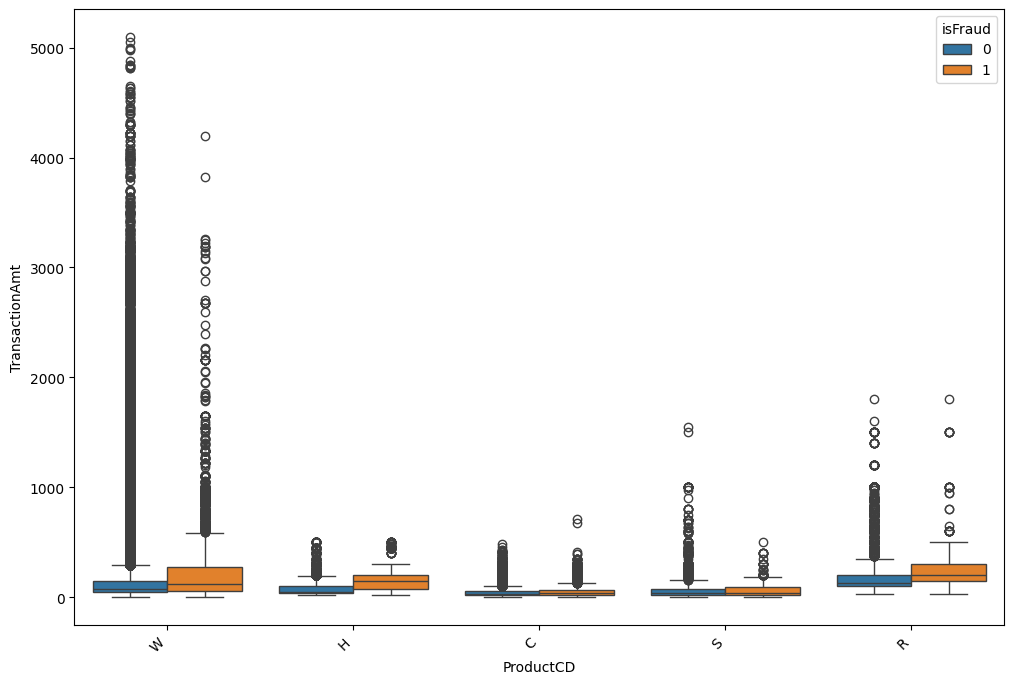

In [131]:
plt.figure(figsize=(12, 8))
sns.boxplot(data=df_train, x='ProductCD', y='TransactionAmt',hue='isFraud')
plt.xlabel('ProductCD')
plt.ylabel('TransactionAmt')
plt.title('Boxplot de TransactionAmt por ProductCD')
plt.xticks(rotation=45, ha='right')
plt.show()

In [134]:
# Eliminar filas con valores NaN en 'TransactionAmt'
df_train_clean = df_train.dropna(subset=['TransactionAmt'])

# Calcular estadísticas descriptivas
stats_prod = df_train_clean.groupby(['ProductCD', 'isFraud'])['TransactionAmt'].describe().round(2)

# Mostrar el resultado
print(stats_prod)

                      count   mean  std    min     25%     50%     75%     max
ProductCD isFraud                                                             
C         0         60511.0    inf  inf   0.25   18.12   30.78   52.69   486.5
          1          8008.0    inf  inf   0.29   20.18   34.81   64.34   713.0
H         0         31450.0    inf  inf  15.00   35.00   50.00  100.00   500.0
          1          1574.0    inf  inf  15.00   75.00  150.00  200.00   500.0
R         0         36273.0    inf  inf  25.00  100.00  125.00  200.00  1800.0
          1          1426.0    inf  inf  25.00  150.00  200.00  300.00  1800.0
S         0         10942.0    inf  inf   5.00   20.00   35.00   75.00  1550.0
          1           686.0  63.31  inf   5.00   20.00   35.00   90.00   500.0
W         0        430687.0    NaN  NaN   1.00   49.00   77.94  146.00  5096.0
          1          8968.0    inf  inf   1.00   59.00  117.00  270.00  4192.0


- Observando las medianas, notamos que para 'C' y 'S' son prácticamente iguales. 'H' difiere notablemente con una mediana aproximadamente tres veces mayor, mientras que 'R' muestra una diferencia de casi el doble. Por otro lado, 'W' exhibe una mediana casi el doble en comparación con los otros.

### Característica Addr

**addr**: dirección.
- "Ambas direcciones son para el comprador: addr1 como región de facturación, addr2 como país de facturación."

In [113]:
df_train['addr1'].dtype

dtype('float16')

In [114]:
df_filtered = df_train.dropna(subset=['addr1']).copy()
df_filtered['addr1'] = df_filtered['addr1'].astype(int)

# Calcular el tamaño de cada grupo
addr = df_filtered.groupby('addr1').size()

# Crear el DataFrame resultado
addr_resultado = addr.reset_index(name='N° Registros')
addr_resultado['Porcentaje %'] = round((addr_resultado['N° Registros'] / addr_resultado['N° Registros'].sum()) * 100, 2)
addr_resultado = addr_resultado.sort_values(by='N° Registros', ascending=False)
addr_resultado.head(5)

,addr1,N° Registros,Porcentaje %
151,299,46335,8.83
173,325,42751,8.15
78,204,42018,8.01
127,264,39870,7.60
178,330,26286,5.01


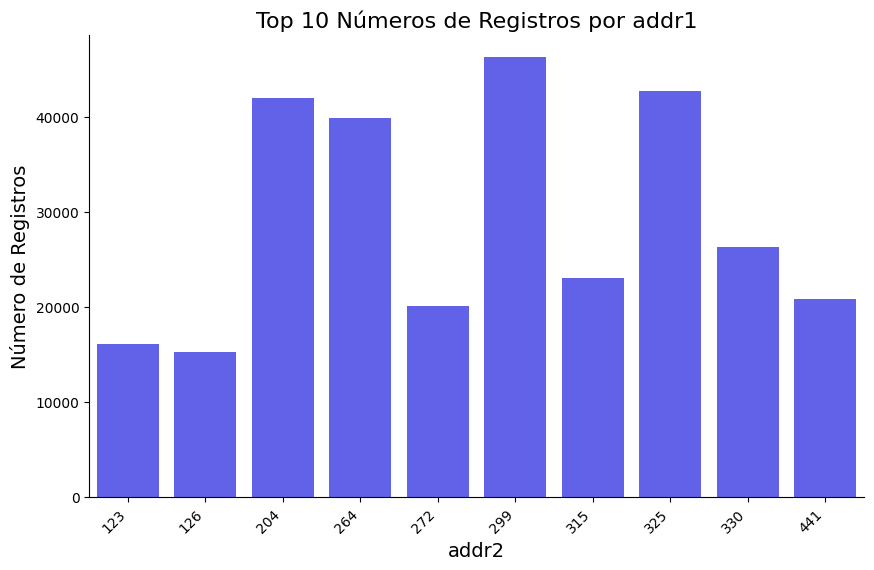

In [115]:
top_10 = addr_resultado.head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x='addr1', y='N° Registros', data=top_10, color='blue', alpha=0.7)
plt.title('Top 10 Números de Registros por addr1', fontsize=16)
plt.xlabel('addr2', fontsize=14)
plt.ylabel('Número de Registros', fontsize=14)
plt.xticks(rotation=45, ha='right')
sns.despine()
plt.show()


En la tabla de arriba muestra las 10 regiones con mayor transacciones

In [116]:
df_filtered = df_train.dropna(subset=['addr2']).copy()
df_filtered['addr2'] = df_filtered['addr2'].astype(int)

# Calcular el tamaño de cada grupo
addr = df_filtered.groupby('addr2').size()

# Crear el DataFrame resultado
addr_resultado = addr.reset_index(name='N° Registros')
addr_resultado['Porcentaje %'] = round((addr_resultado['N° Registros'] / addr_resultado['N° Registros'].sum()) * 100, 2)
addr_resultado = addr_resultado.sort_values(by='N° Registros', ascending=False)
addr_resultado.head(5)

,addr2,N° Registros,Porcentaje %
62,87,520466,99.17
40,60,3084,0.59
68,96,638,0.12
20,32,91,0.02
44,65,82,0.02


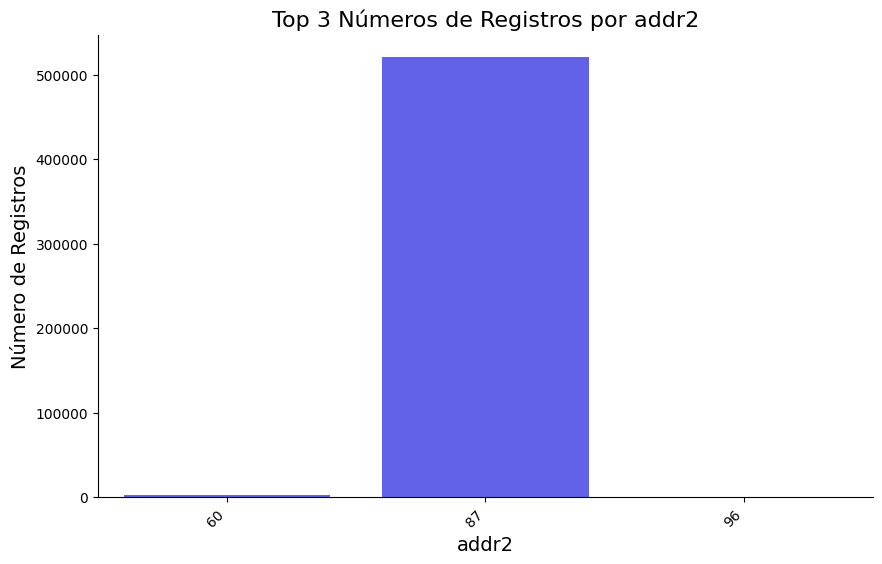

In [117]:
top_10 = addr_resultado.head(3)
plt.figure(figsize=(10, 6))
sns.barplot(x='addr2', y='N° Registros', data=top_10, color='blue', alpha=0.7)
plt.title('Top 3 Números de Registros por addr2', fontsize=16)
plt.xlabel('addr2', fontsize=14)
plt.ylabel('Número de Registros', fontsize=14)
plt.xticks(rotation=45, ha='right')
sns.despine()
plt.show()


**Obervación:**
La gráfica anterior muestra los tres países con el mayor número de transacciones. El país con el código 87 tiene la mayor cantidad de transacciones, casi el 99% de las transacciones.


### Columna P_emaildomain

**P_emaildomain**: dominio de correo electrónico del comprador.

In [118]:
df_train['P_emaildomain'].value_counts().head(10)

P_emaildomain
gmail.com        228351
yahoo.com        100929
hotmail.com       45249
anonymous.com     36998
aol.com           28289
comcast.net        7888
icloud.com         6266
outlook.com        5096
msn.com            4091
att.net            4033
Name: count, dtype: int64

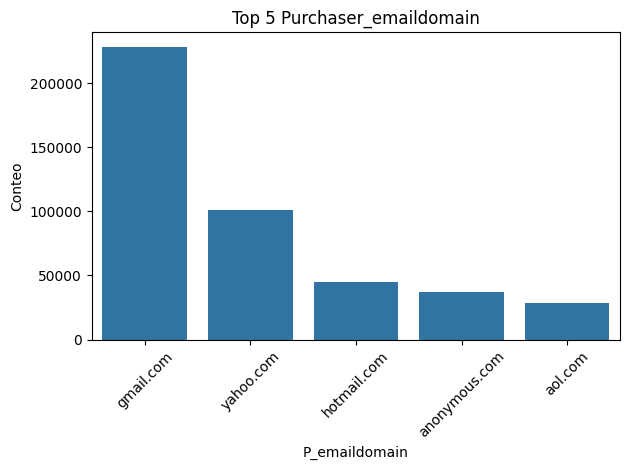

In [119]:
top_5_values = df_train['P_emaildomain'].value_counts().head(5)
sns.countplot(data=df_train, x='P_emaildomain', order=top_5_values.index)
plt.xticks(rotation=45)
plt.title('Top 5 Purchaser_emaildomain')
plt.xlabel('P_emaildomain')
plt.ylabel('Conteo')
plt.tight_layout()
#plt.savefig(base_dir+ 'emaildomaintop5')

plt.show()

**Observación:** Dominio de correo electrónico del comprador (purchaser) y del destinatario (recipient) respectivamente la mayor parte de la transacción lo hace con "gmail"

## Car


**card1 - card6**: información de la tarjeta de pago, como tipo de tarjeta, categoría de tarjeta, banco emisor, país, etc.
- "Información de la tarjeta de pago, como tipo de tarjeta, categoría de tarjeta, banco emisor, país, etc."

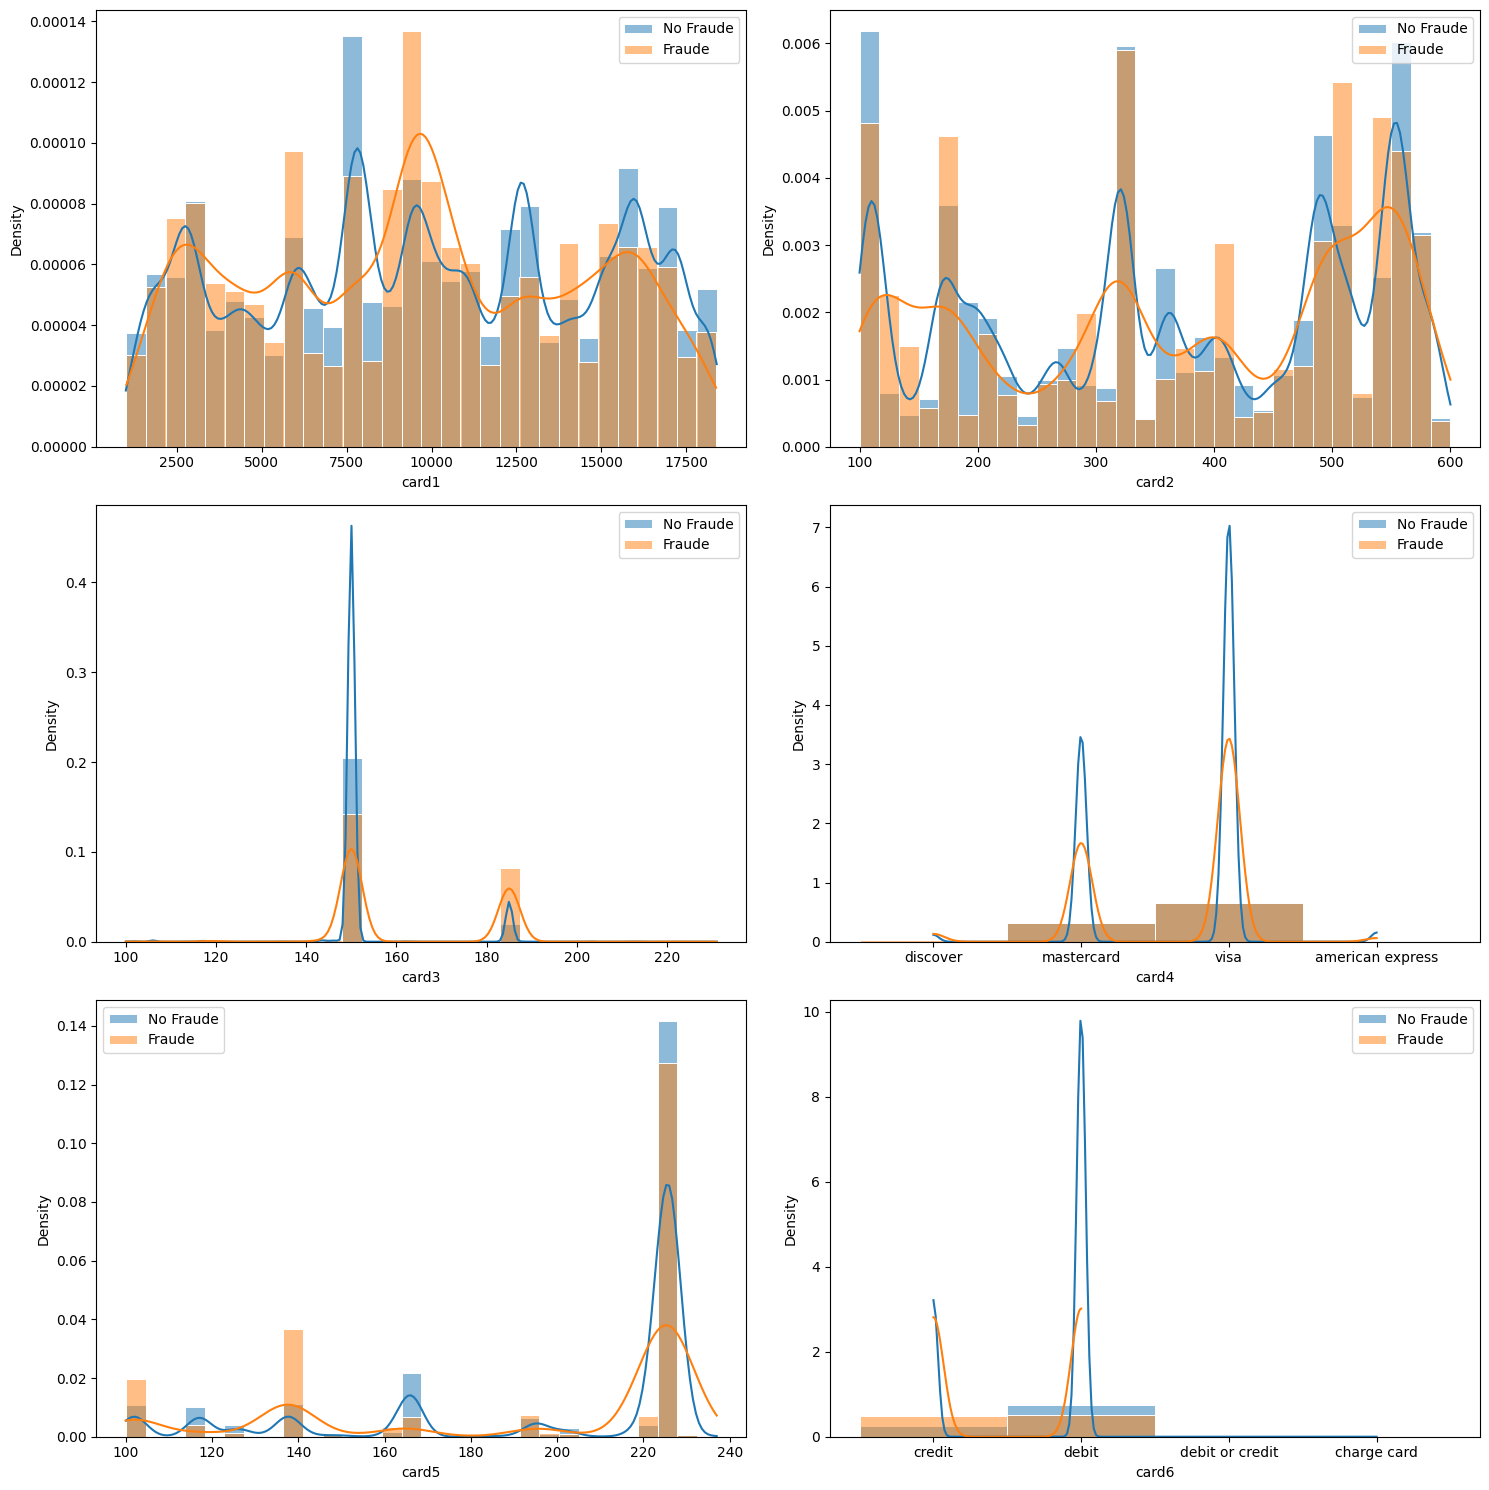

In [137]:
import matplotlib.pyplot as plt
import seaborn as sns

cards = ['card1', 'card2', 'card3', 'card4', 'card5', 'card6']

# Crear subplots para cada variable de tarjeta
fig, axs = plt.subplots(3, 2, figsize=(15, 15), sharey=False, tight_layout=True)

# Iterar sobre las variables de tarjeta y los subplots correspondientes
for i, card in enumerate(cards):
    # Histograma de densidad para datos no fraudulentos
    sns.histplot(data=df_train[df_train['isFraud'] == 0], x=card, bins=30,
                 edgecolor="white", linewidth=0.7, log_scale=False, ax=axs[i//2, i%2], color='tab:blue', label='No Fraude', kde=True, stat='density')

    # Histograma de densidad para datos fraudulentos
    sns.histplot(data=df_train[df_train['isFraud'] == 1], x=card, bins=30,
                 edgecolor="white", linewidth=0.7, log_scale=False, ax=axs[i//2, i%2], color='tab:orange', label='Fraude', kde=True, stat='density')

    # Configuraciones adicionales para cada subplot
    axs[i//2, i%2].set_xlabel(card)
    axs[i//2, i%2].legend()

# Ajustar el espacio entre subplots y mostrar la figura
plt.tight_layout()
plt.show()


In [150]:
stat_card = df_train.groupby('isFraud')[cards].describe().T.round(2)
stat_card

isFraud              0         1
card1 count  569863.00  20662.00
      mean     9911.44   9547.66
      std      4905.68   4762.17
      min      1000.00   1015.00
      25%      6019.00   5723.25
      50%      9711.00   9633.00
      75%     14229.00  13623.00
      max     18396.00  18375.00
card2 count  561353.00  20239.00
      mean         NaN       inf
      std          NaN       inf
      min       100.00    100.00
      25%       215.00    204.00
      50%       361.00    375.00
      75%       512.00    514.00
      max       600.00    600.00
card3 count  568337.00  20623.00
      mean         NaN       inf
      std         0.00     17.50
      min       100.00    100.00
      25%       150.00    150.00
      50%       150.00    150.00
      75%       150.00    185.00
      max       231.00    231.00
card5 count  565814.00  20452.00
      mean         NaN       inf
      std         0.00     45.78
      min       100.00    100.00
      25%       166.00    138.00
      50%       226.00    224.00
      75%       226.00    226.00
      max       237.00    237.00

- Las variables Card1 y Card2 son valores numéricos. En la gráfica de distribución, se observa que sus distribuciones normalizadas no muestran grandes diferencias entre los casos con fraude y sin fraude. Además, los valores estadísticos, como la media y la dispersión, son muy similares para ambos grupos.
- Lo mismo ocurre con las variables categóricas Card3 y Card5, donde los valores más frecuentes coinciden. Sin embargo, en Card5, se observa que hay ciertos valores para los cuales la frecuencia es más alta en los casos de fraude en comparación con los no fraudulentos, lo que indica una diferencia en la distribución entre ambos grupos.
- En Card4, las empresas emisoras de tarjetas muestran la misma distribución tanto en casos de fraude como en casos no fraudulentos.
- Sin embargo, en Card6, que representa el tipo de pago (tarjeta o débito), se observan diferencias significativas en las distribuciones entre ambos grupos

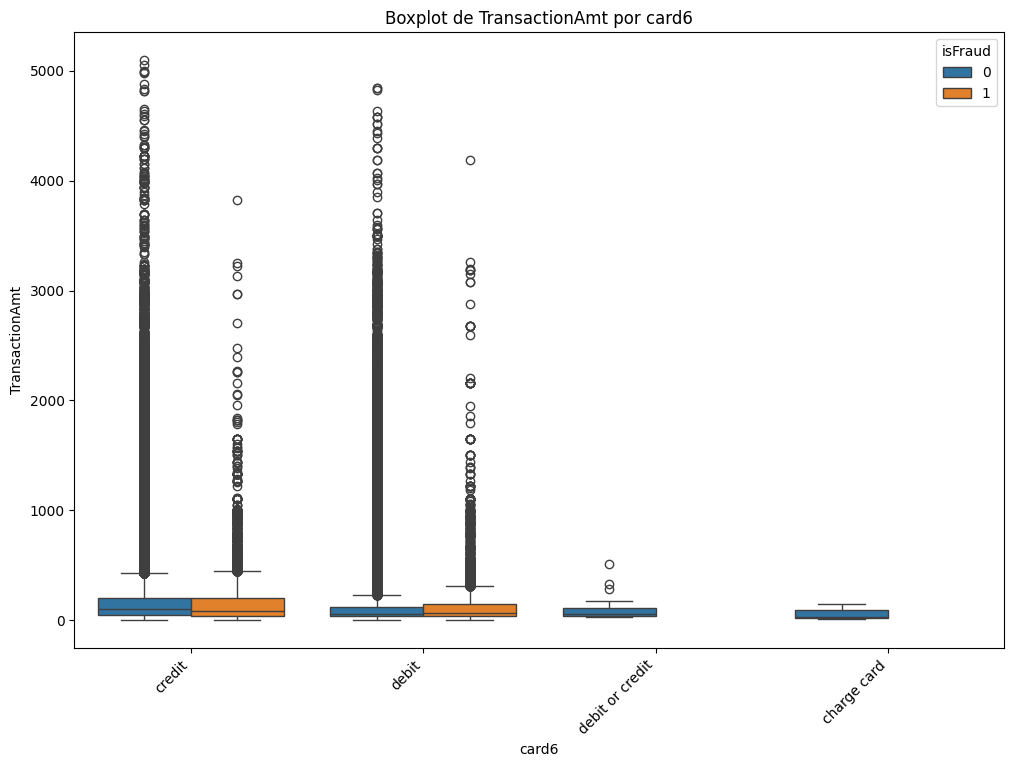

In [153]:
plt.figure(figsize=(12, 8))
sns.boxplot(data=df_train, x='card6', y='TransactionAmt',hue='isFraud')
plt.xlabel('card6')
plt.ylabel('TransactionAmt')
plt.title('Boxplot de TransactionAmt por card6')
plt.xticks(rotation=45, ha='right')
plt.show()

In [159]:
# Eliminar filas con valores NaN en 'TransactionAmt'
df_train_clean = df_train.dropna(subset=['TransactionAmt'])

# Calcular estadísticas descriptivas
stats_prod = df_train_clean.groupby(['card6', 'isFraud'])['TransactionAmt'].describe().round(2)

# Mostrar el resultado
stats_prod

count    mean    std    min    25%     50%  \
card6           isFraud                                                  
charge card     0            15.0   59.53  52.25  11.08  21.34   28.52   
credit          0        139027.0     NaN    NaN   0.27  50.00  100.00   
                1          9950.0     inf    inf   0.42  34.75   80.00   
debit           0        429259.0     NaN    NaN   0.25  40.00   59.00   
                1         10673.0     inf    inf   0.29  35.56   66.69   
debit or credit 0            30.0  104.06    inf  25.00  35.95   58.72   

                            75%     max  
card6           isFraud                  
charge card     0         91.28   150.0  
credit          0        200.00  5096.0  
                1        200.00  3822.0  
debit           0        117.00  4844.0  
                1        146.00  4192.0  
debit or credit 0        108.44   512.5

- En la categoría de crédito, se observa una diferencia del 10% en la mediana, mientras que los otros cuartiles son prácticamente similares.
- Por otro lado, en la categoría de débito, la diferencia en la mediana es del 5%; el cuartil Q2 casi coincide, pero no así el cuartil Q3.

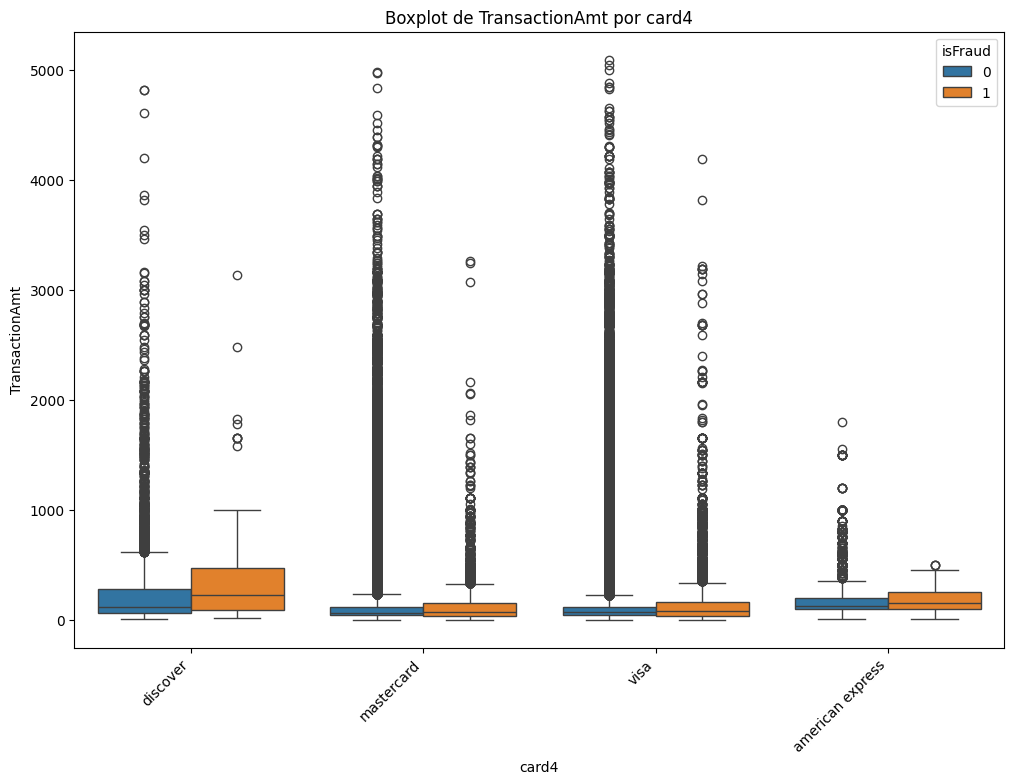

In [162]:
plt.figure(figsize=(12, 8))
sns.boxplot(data=df_train, x='card4', y='TransactionAmt',hue='isFraud')
plt.xlabel('card4')
plt.ylabel('TransactionAmt')
plt.title('Boxplot de TransactionAmt por card4')
plt.xticks(rotation=45, ha='right')
plt.show()

In [165]:
# Eliminar filas con valores NaN en 'TransactionAmt'
df_train_clean = df_train.dropna(subset=['TransactionAmt'])

# Calcular estadísticas descriptivas
stats_prod = df_train_clean.groupby(['card4', 'isFraud'])['TransactionAmt'].describe().round(2)

# Mostrar el resultado

stats_prod

count   mean  std    min     25%     50%     75%  \
card4            isFraud                                                        
american express 0          8089.0    inf  inf   5.00  100.00  125.00  200.00   
                 1           239.0  179.0  inf   5.00  100.00  150.00  250.00   
discover         0          6137.0    inf  inf   5.00   57.94  115.00  280.00   
                 1           514.0    inf  inf  15.00   90.00  226.00  470.00   
mastercard       0        182713.0    NaN  NaN   0.27   39.00   62.03  117.00   
                 1          6496.0    inf  inf   0.47   32.34   65.81  150.00   
visa             0        371388.0    NaN  NaN   0.25   44.00   68.50  117.00   
                 1         13372.0    inf  inf   0.29   35.93   75.00  158.16   

                             max  
card4            isFraud          
american express 0        1800.0  
                 1         500.0  
discover         0        4816.0  
                 1        3134.0  
mastercard       0        4988.0  
                 1        3260.0  
visa             0        5096.0  
                 1        4192.0

- Se observa una notable diferencia en las distribuciones entre las distintas empresas de tarjeta de crédito. Discover muestra la mayor disparidad entre fraude y no fraude; se pueden apreciar estas diferencias en los valores de sus cuartiles. Le sigue American Express en términos de divergencia entre las distribuciones de fraude y no fraude.

## M1-M9

In [168]:
M = ['M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9']

['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain', 'R_emaildomain', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V50', 'V51', 'V52', 'V53', 'V54', 'V55', 'V56', 'V57', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V65', 'V66', 'V67', 'V68', 'V69', 'V70', 'V71', 'V72', 'V73', 'V74', 'V75', 'V76', 'V77', 'V78', 'V79', 'V80', 'V81', 'V

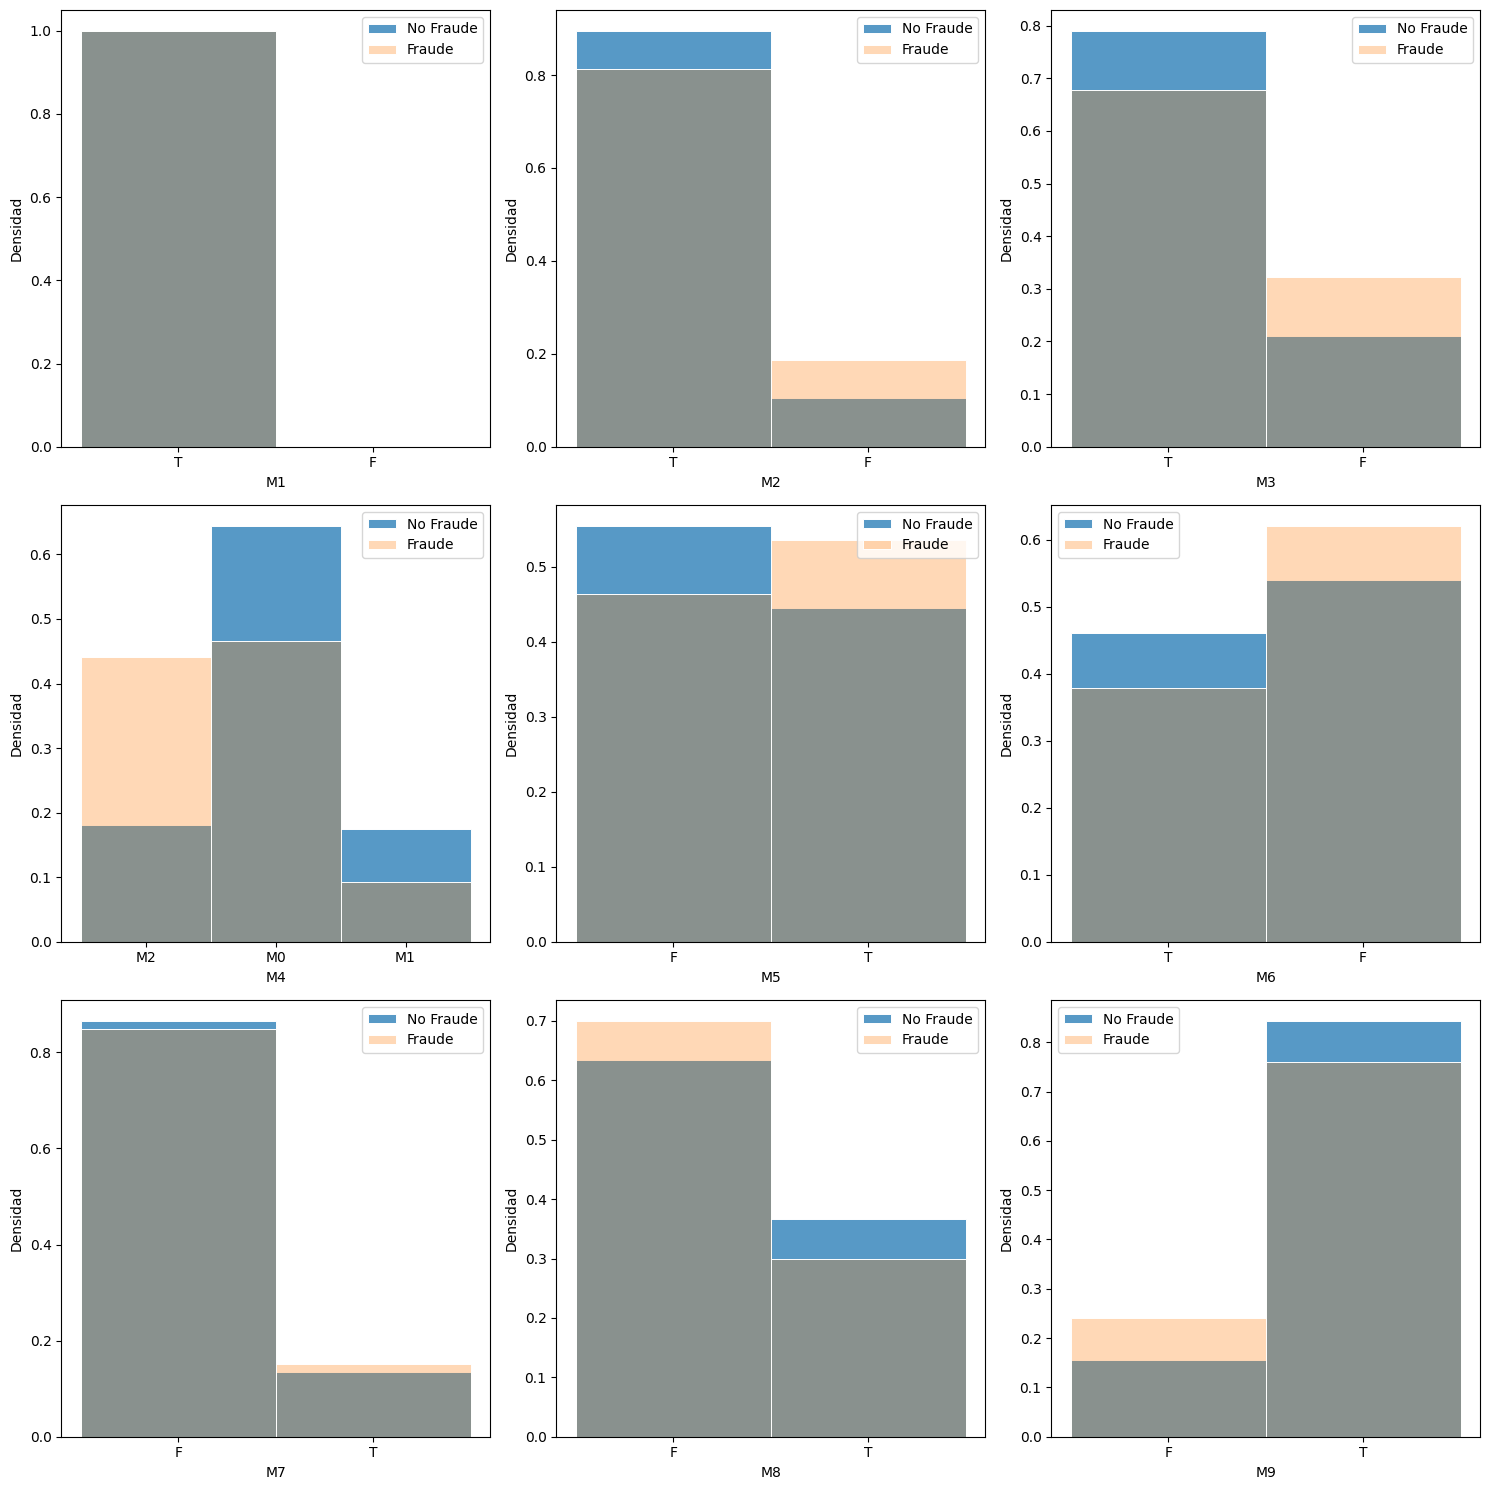

In [192]:


M = ['M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9']

# Crear subplots para cada variable de tarjeta
fig, axs = plt.subplots(3, 3, figsize=(15, 15), sharey=False, tight_layout=True)

# Iterar sobre las variables de tarjeta y los subplots correspondientes
for i, m in enumerate(M):
    # Histograma de densidad para datos no fraudulentos
    sns.histplot(data=df_train[df_train['isFraud'] == 0], x=m, bins=30,
                 edgecolor="white", linewidth=0.7, log_scale=False, ax=axs[i//3, i%3], color='tab:blue', label='No Fraude', stat='density')

    # Histograma de densidad para datos fraudulentos
    sns.histplot(data=df_train[df_train['isFraud'] == 1], x=m, bins=30,
                 edgecolor="white", linewidth=0.7, log_scale=False, ax=axs[i//3, i%3], color='tab:orange', label='Fraude', stat='density',alpha=0.3)

    # Configuraciones adicionales para cada subplot
    axs[i//3, i%3].set_xlabel(m)
    axs[i//3, i%3].set_ylabel('Densidad')
    axs[i//3, i%3].legend()

# Ajustar el espacio entre subplots y mostrar la figura
plt.tight_layout()
plt.show()


In [190]:
stats_percent = (df_train.groupby('isFraud')[M].count()).round(2)
stats_percent

,M1,M2,M3,M4,M5,M6,M7,M8,M9
isFraud,,,,,,,,,
0,313088,313088,313088,293659,232488,412476,239449,239462,239462
1,6341,6341,6341,15435,7568,8691,4816,4816,4816


-

### **C1-C14**

**C1-C14**: conteo, como cuántas direcciones están asociadas con la tarjeta de pago, etc.
- "Conteos de variables C1-C15: ¿Serían como recuentos de números de teléfono, direcciones de correo electrónico, nombres asociados con el usuario? Tu suposición es buena, además de dispositivos, direcciones IP, dirección de facturación, etc. También son para el comprador y el destinatario, lo que duplica el número."

In [122]:
c_valores = ['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10',
       'C11', 'C12', 'C13', 'C14']

In [123]:
df_train[c_valores].dtypes

C1     float16
C2     float16
C3     float16
C4     float16
C5     float16
C6     float16
C7     float16
C8     float16
C9     float16
C10    float16
C11    float16
C12    float16
C13    float16
C14    float16
dtype: object

In [124]:
df_train[c_valores].describe()

,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14
count,590525.0,590525.0,590525.0,590525.0,590525.0,590525.0,590525.0,590525.0,590525.0,590525.0,590525.0,590525.0,590525.0,590525.0
mean,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
50%,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,3.0,1.0
75%,3.0,3.0,0.0,0.0,1.0,2.0,0.0,0.0,2.0,0.0,2.0,0.0,12.0,2.0
max,4684.0,5692.0,26.0,2252.0,349.0,2252.0,2256.0,3332.0,210.0,3256.0,3188.0,3188.0,2918.0,1429.0


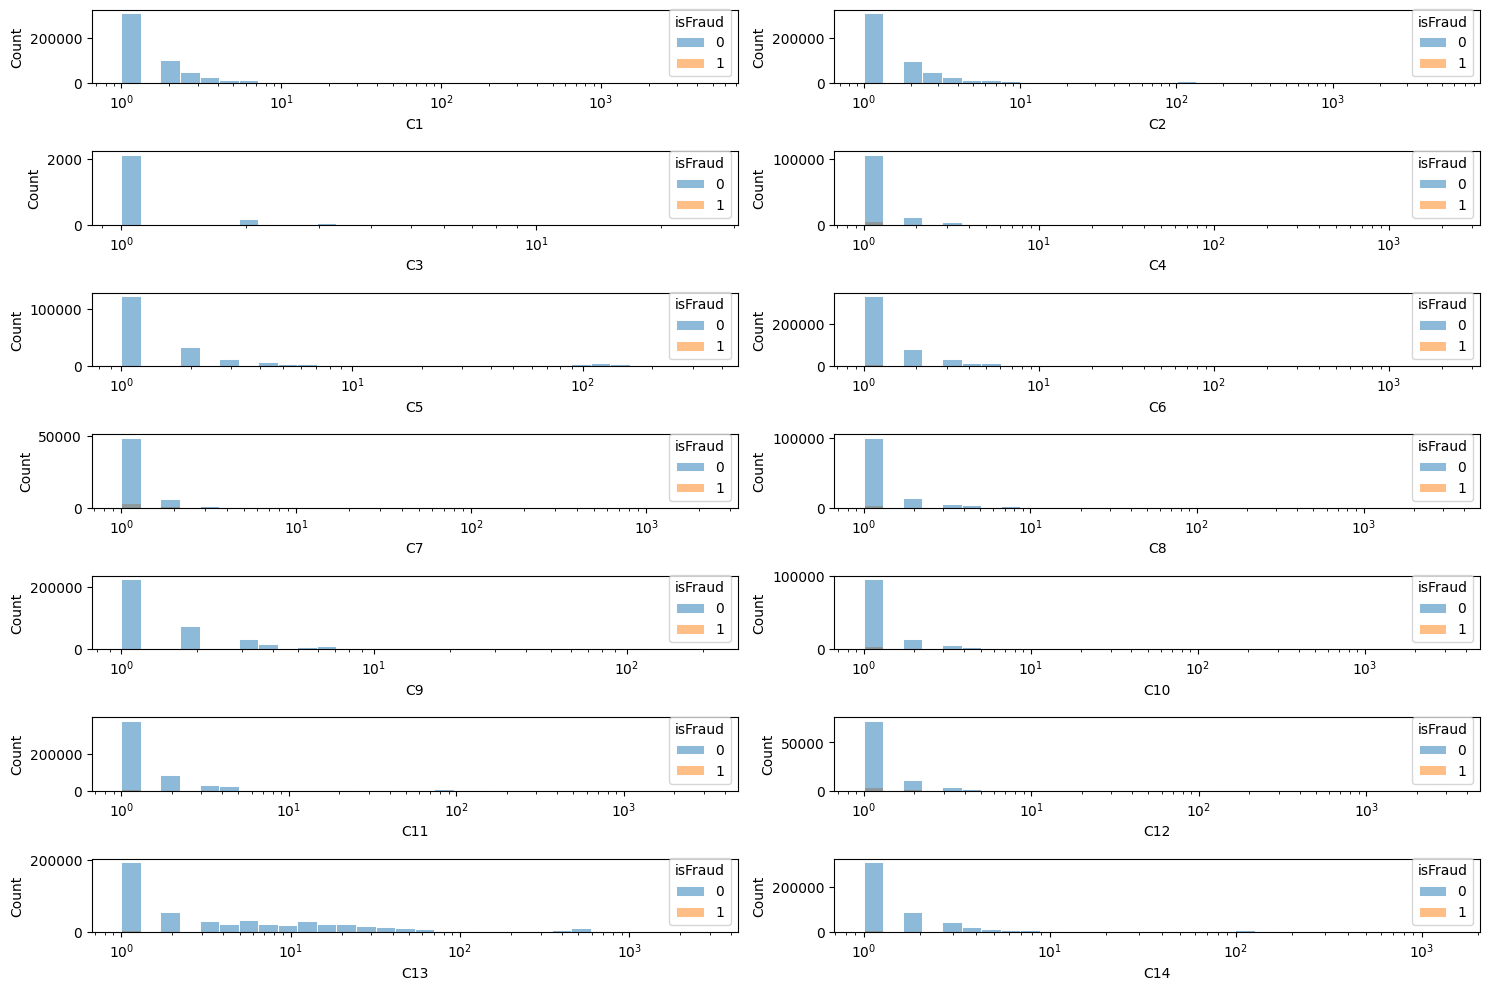

In [125]:


# Crear subplots para cada rango de valor
fig, axs = plt.subplots(7, 2, figsize=(15, 10), sharey=False, tight_layout=True)

# Iterar sobre los subplots y los rangos
for i, ax in enumerate(axs.flatten()):
        sns.histplot(data=df_train, x=c_valores[i], bins=30,
                     edgecolor="white", linewidth=0.7, log_scale=True, ax=ax,hue='isFraud')

# Ajustar el espacio entre subplots y mostrar la figura
plt.tight_layout()
plt.show()


### Análisis Bivariado

### Características Numeŕicas

In [126]:
df_train.columns

Index(['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt',
       'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5',
       ...
       'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38',
       'DeviceType', 'DeviceInfo', 'TransactionAmt_Range'],
      dtype='object', length=435)

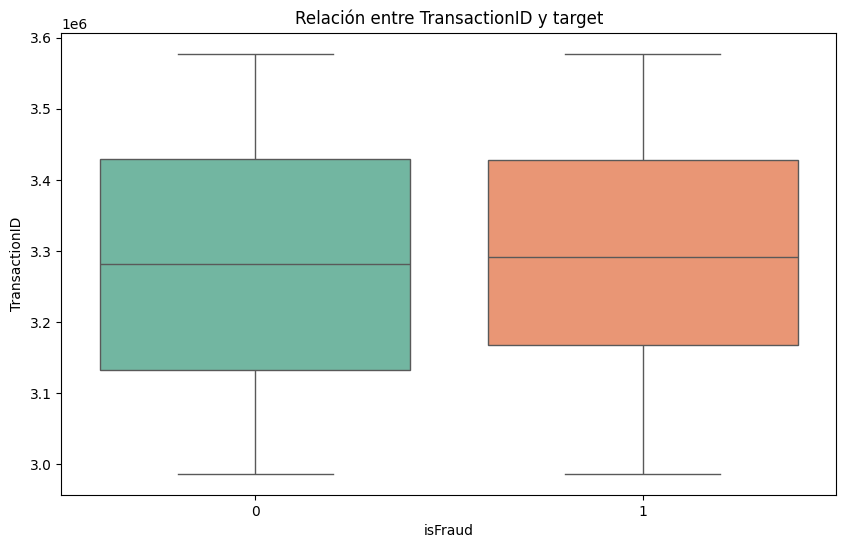

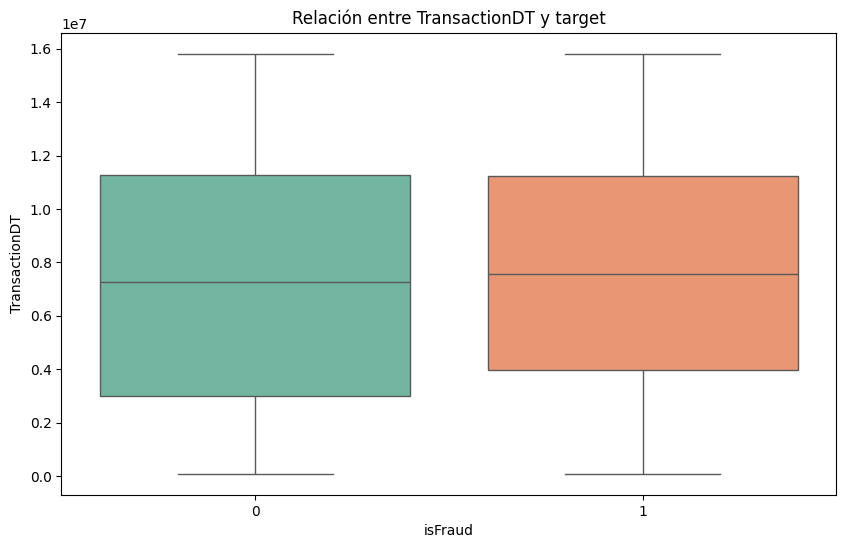

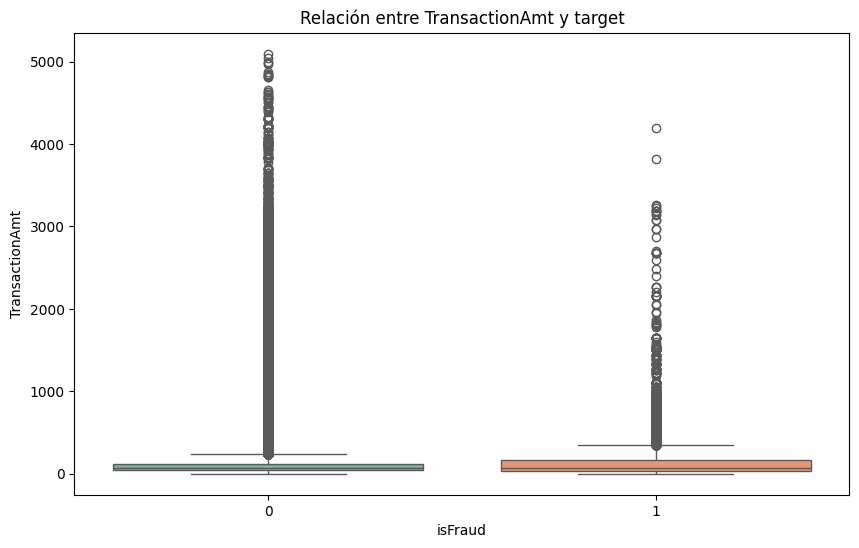

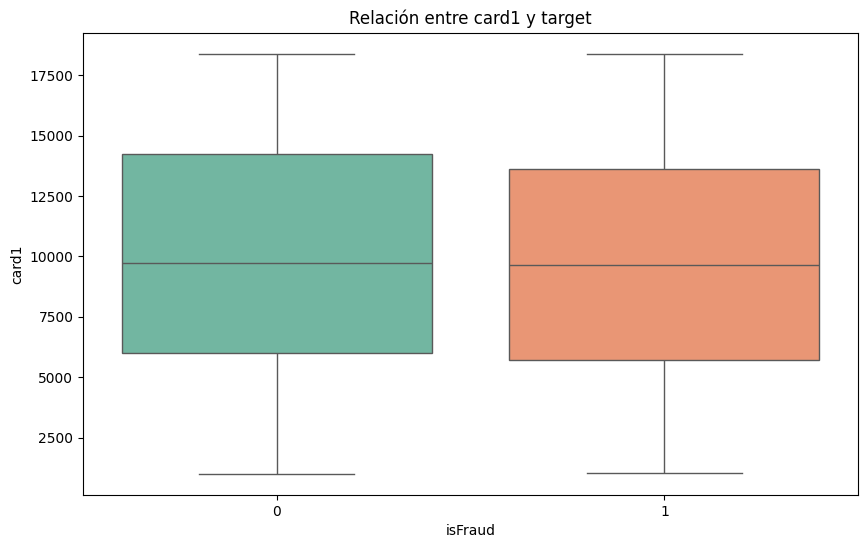

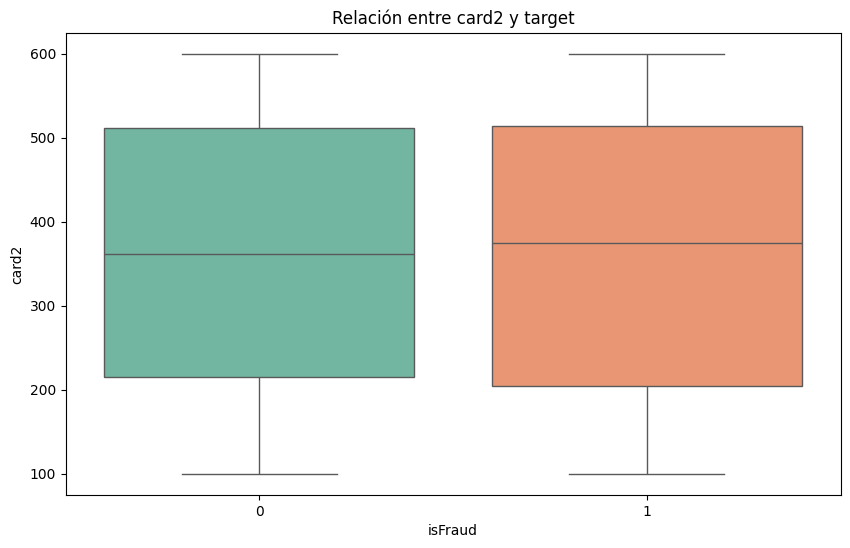

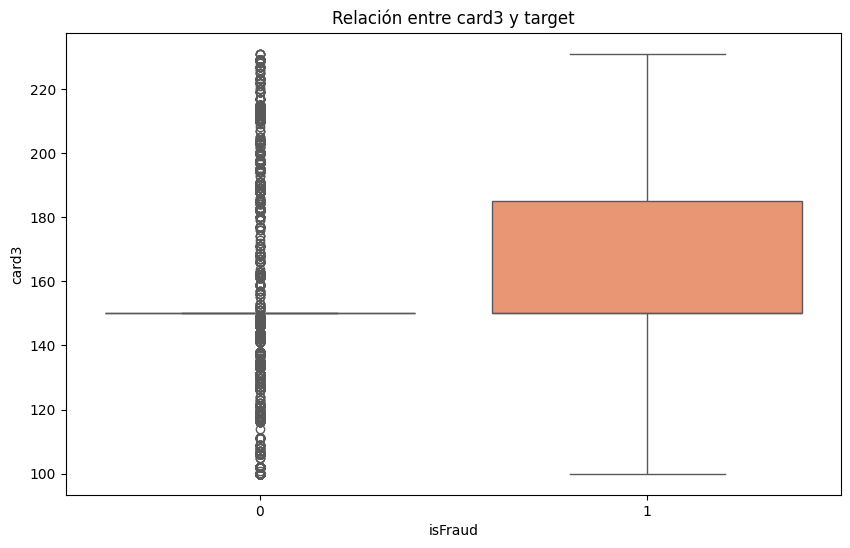

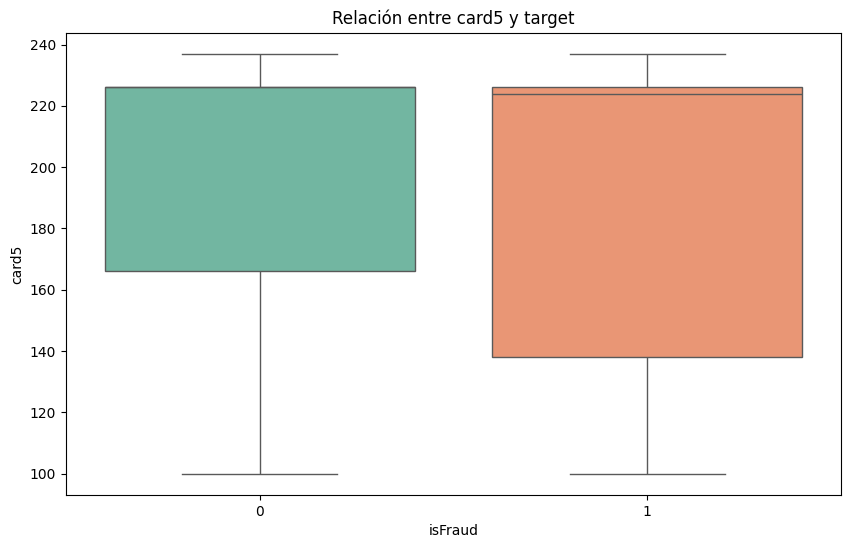

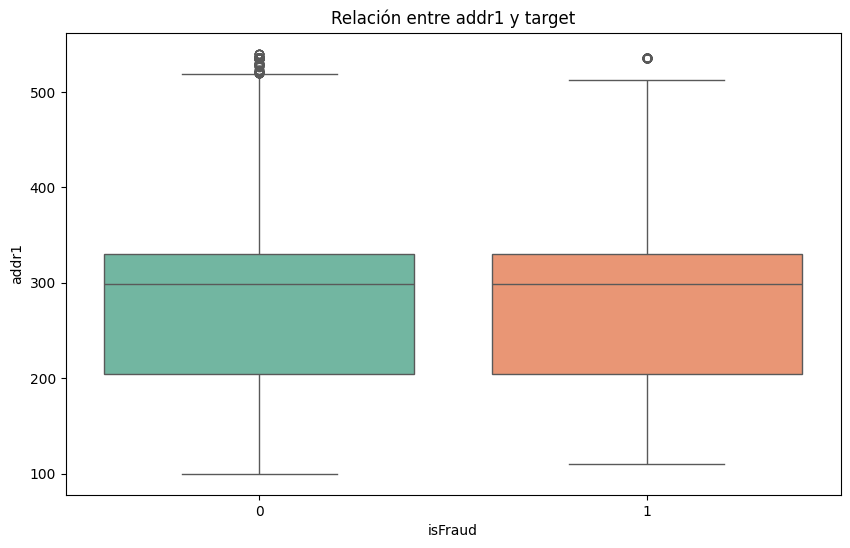

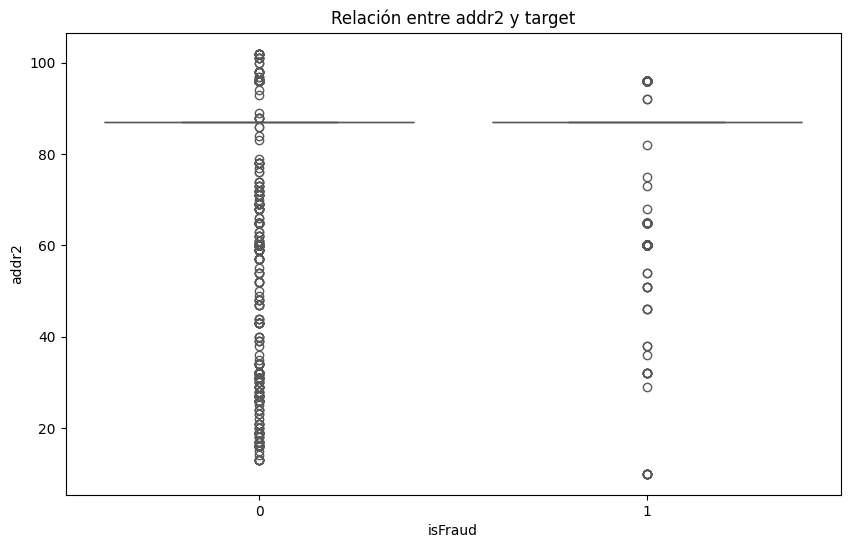

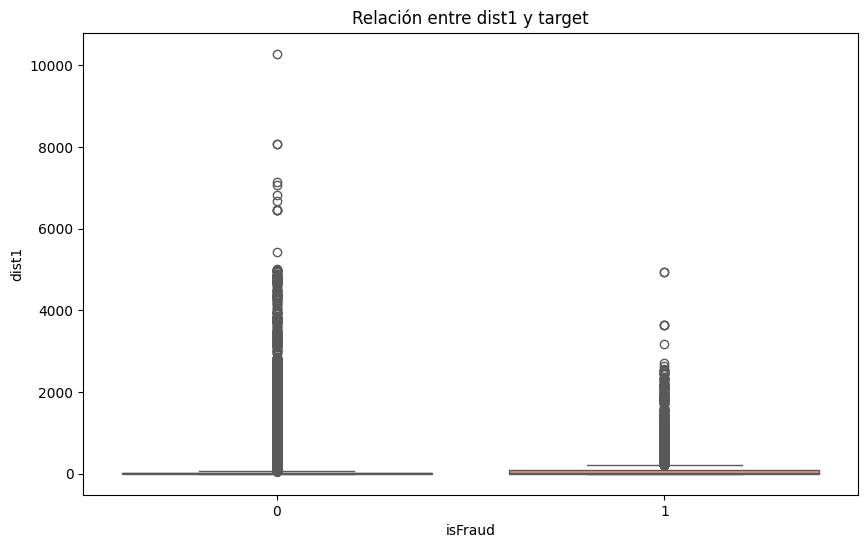

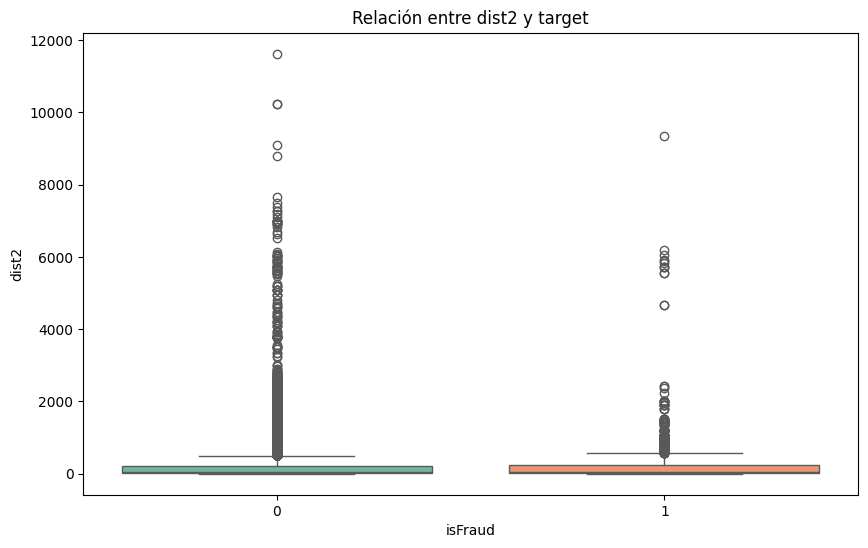

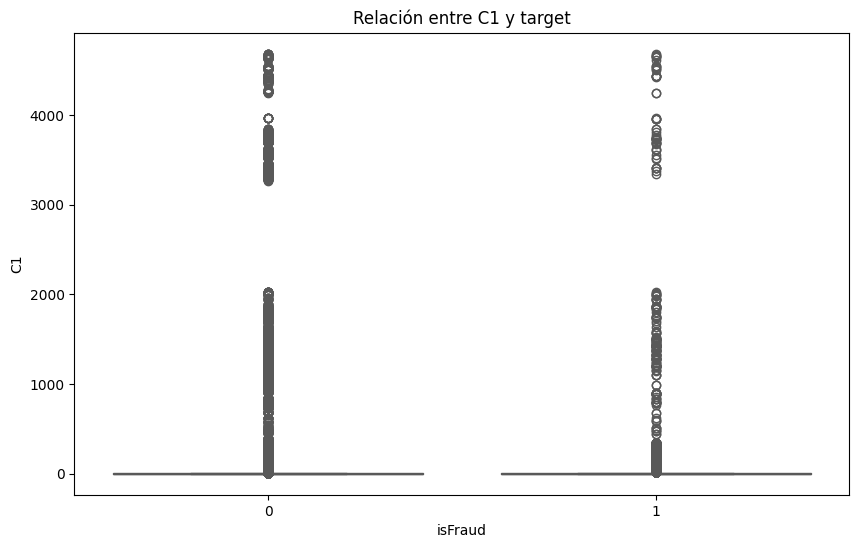

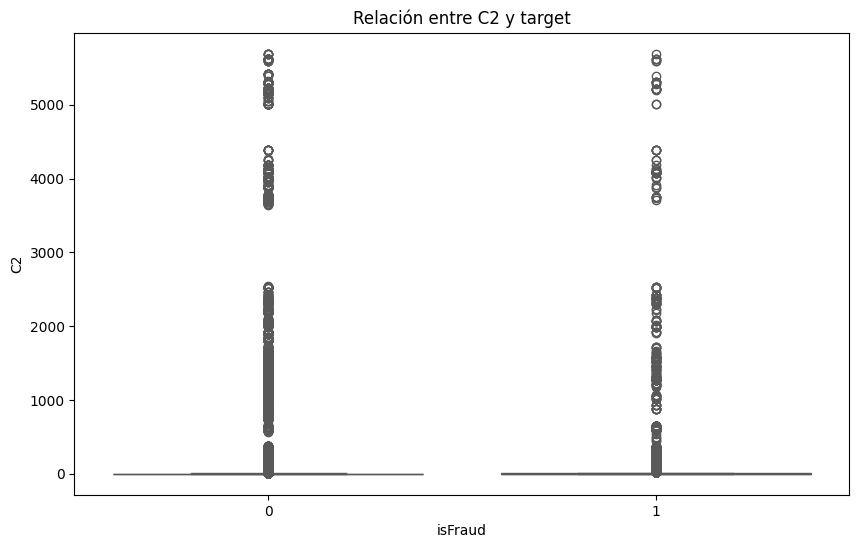

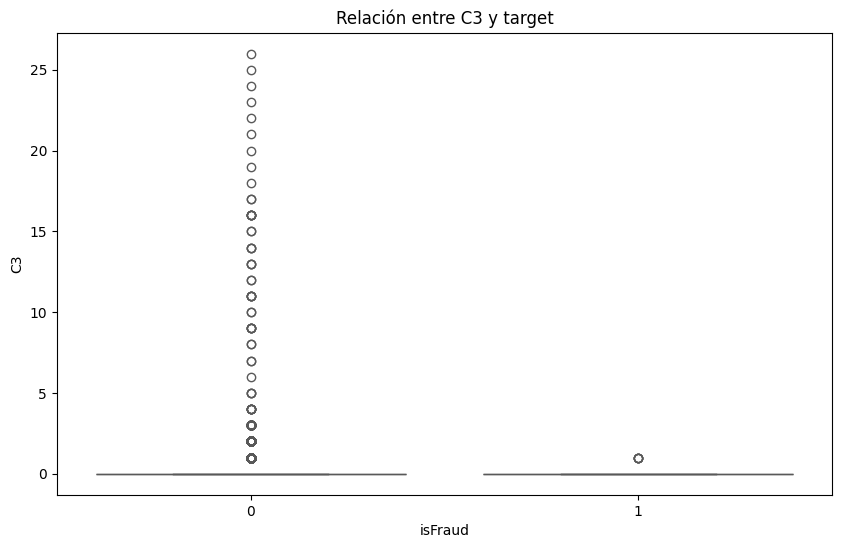

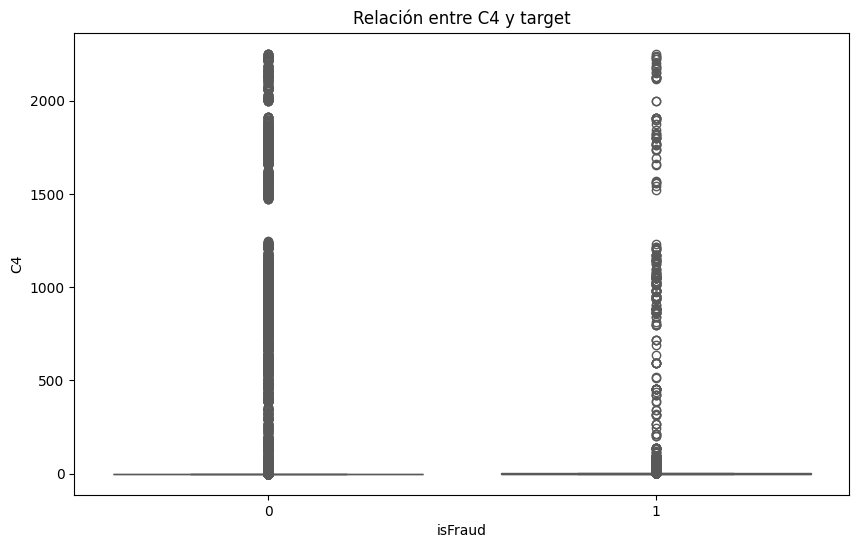

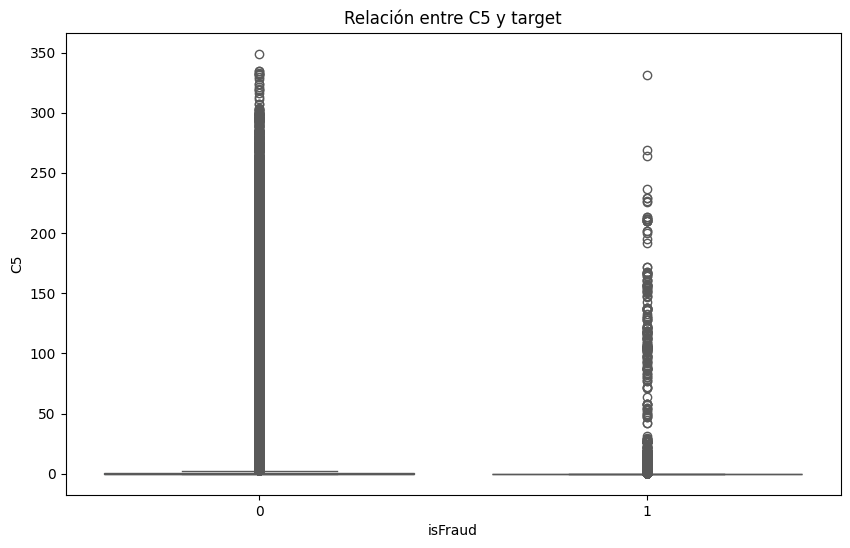

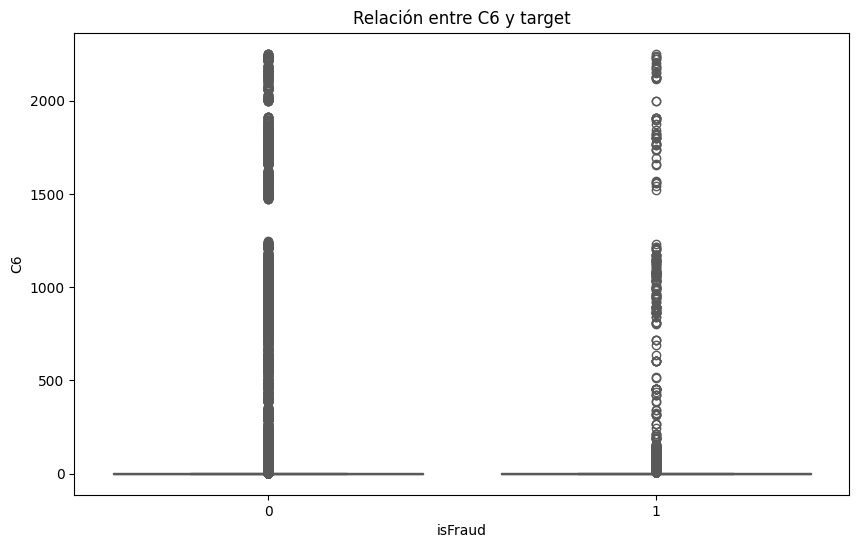

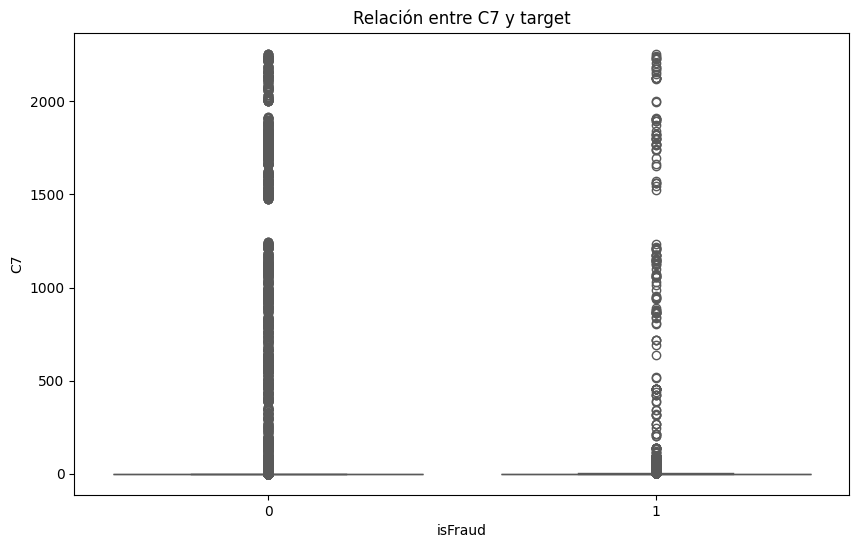

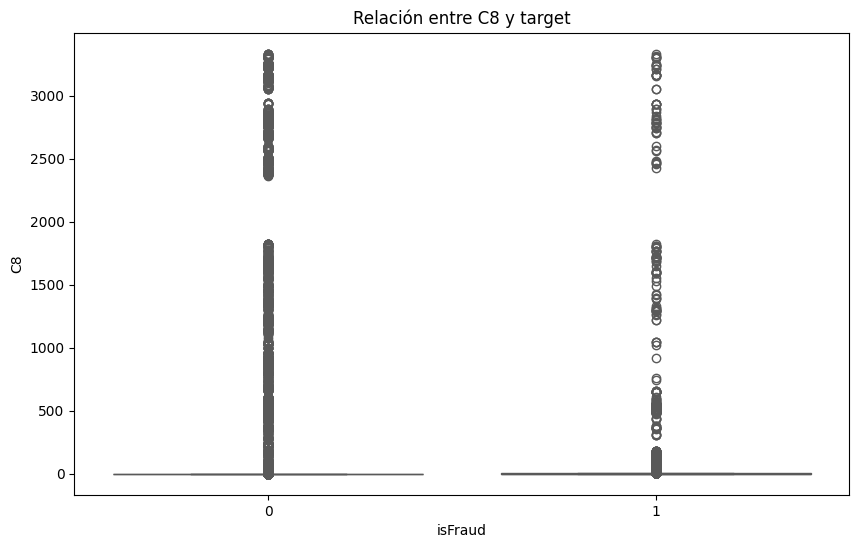

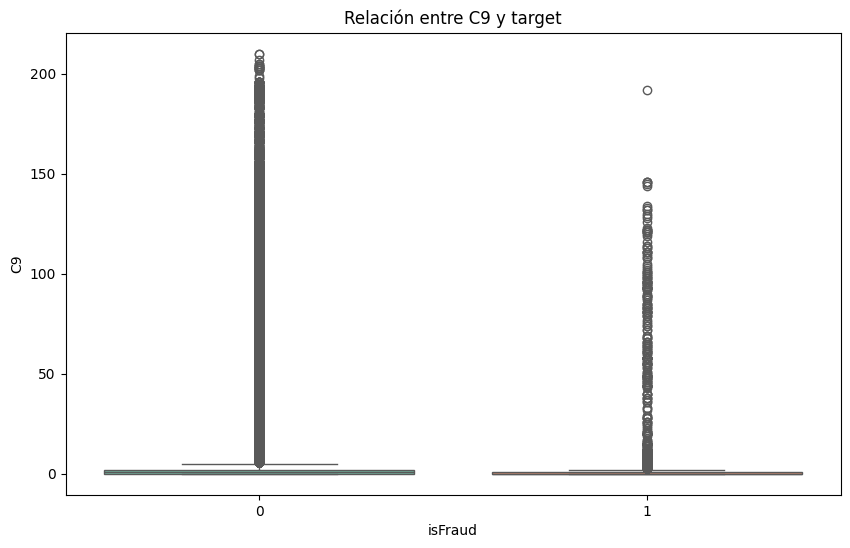

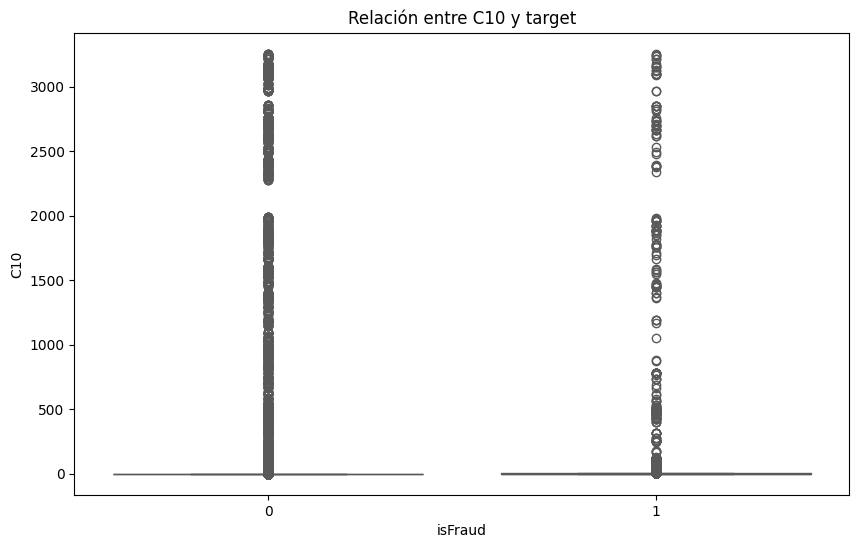

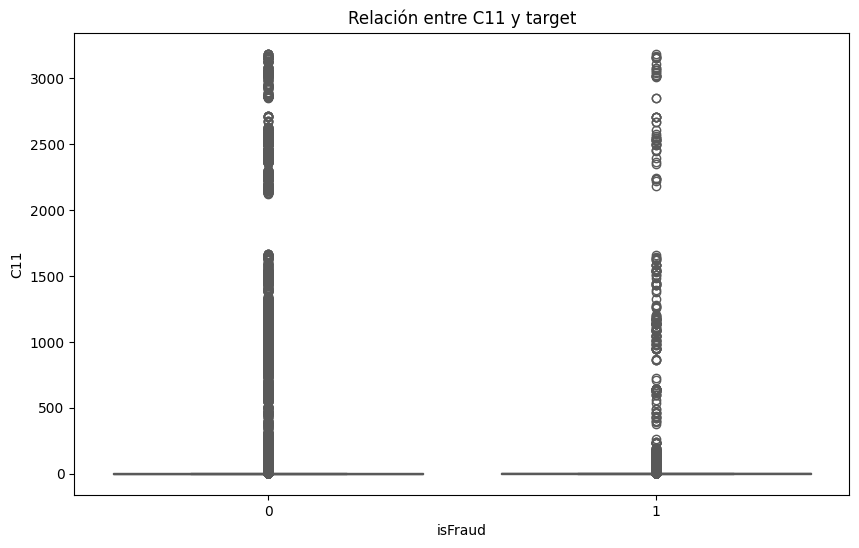

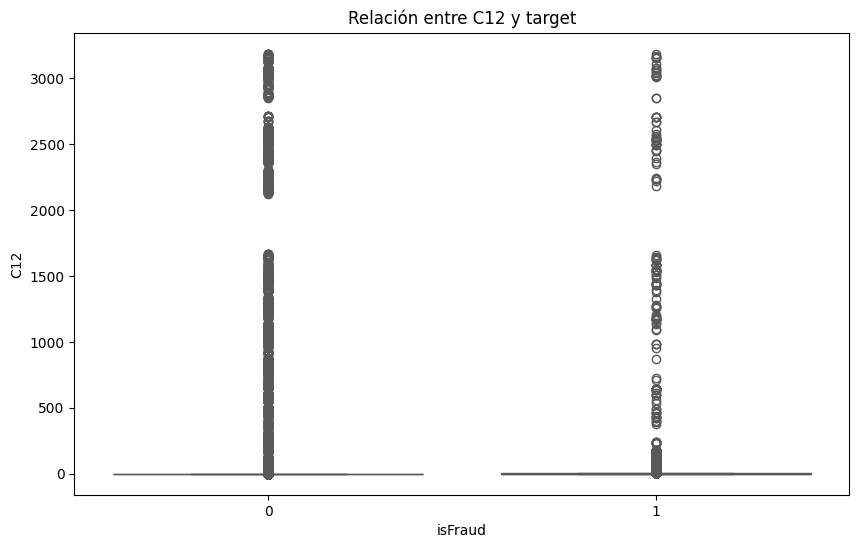

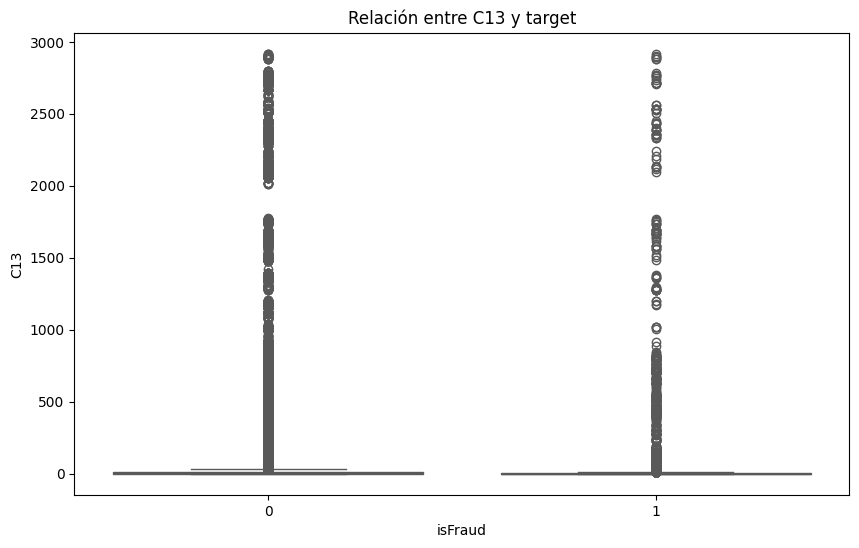

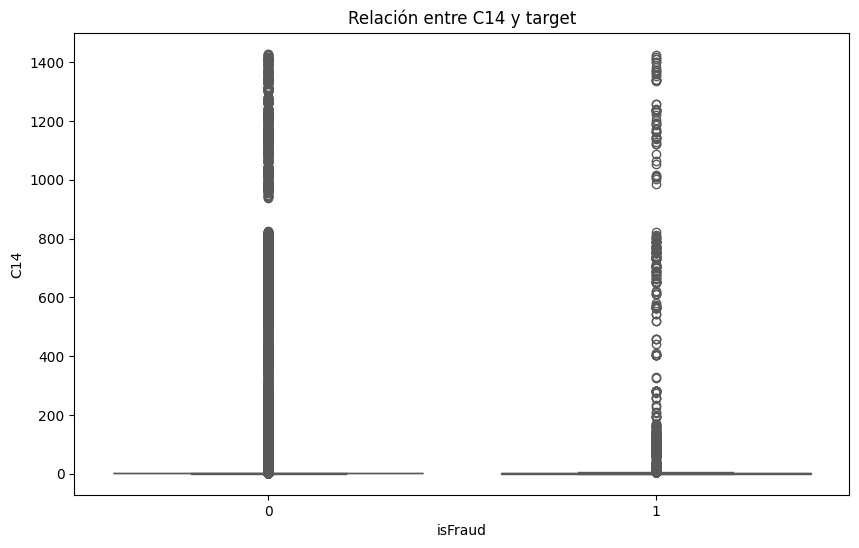

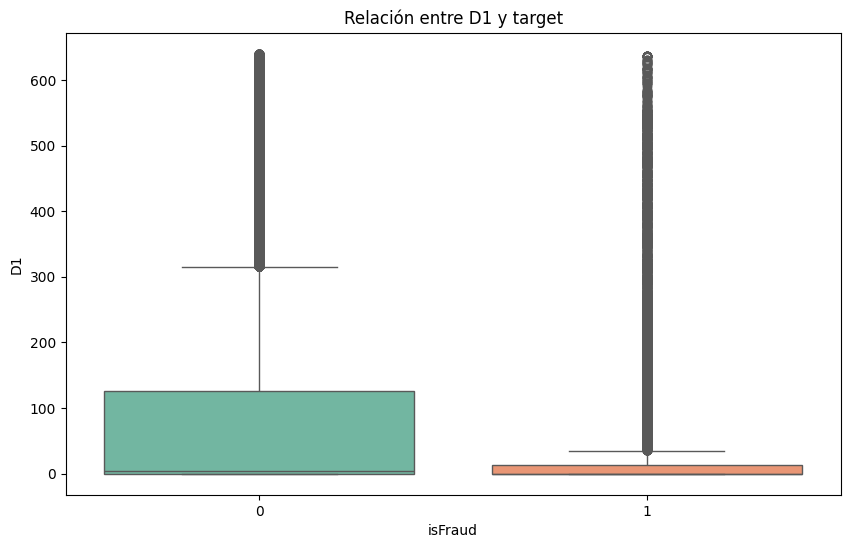

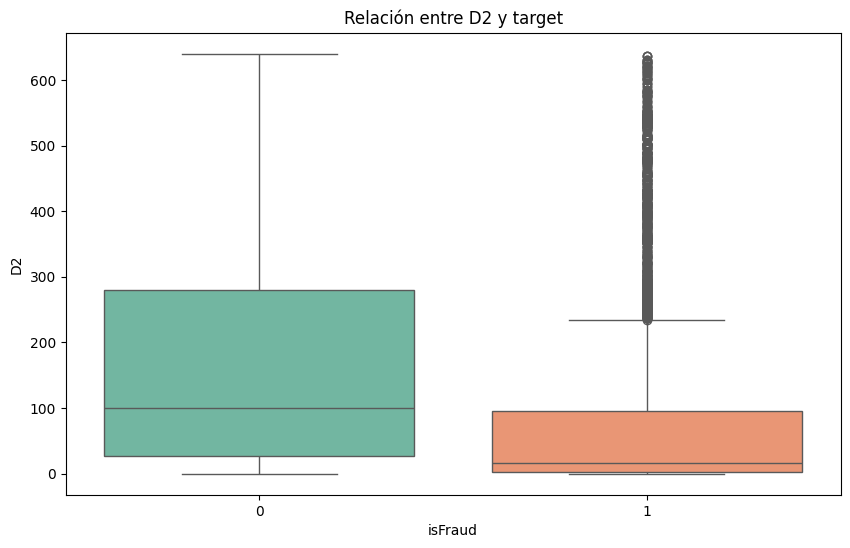

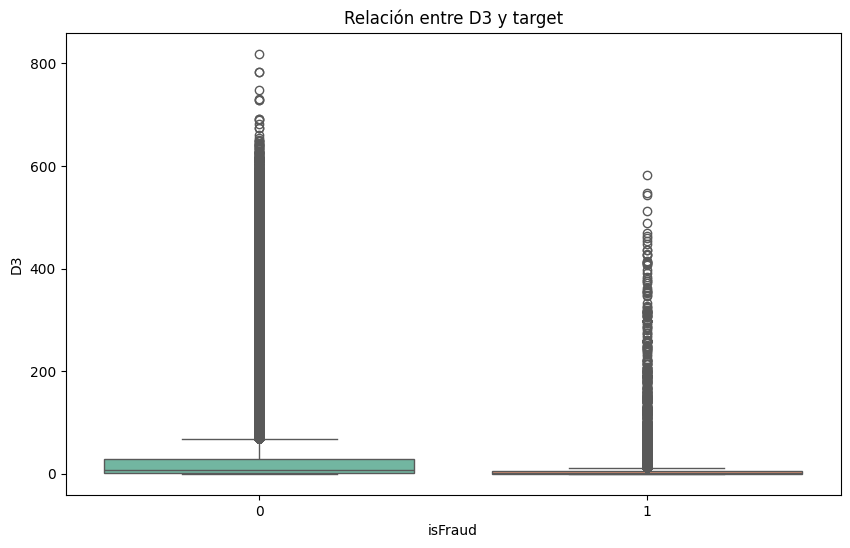

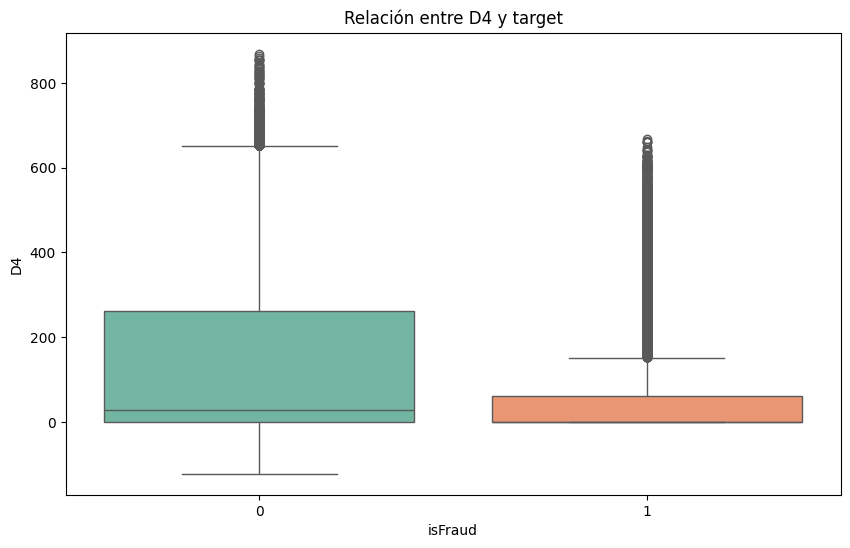

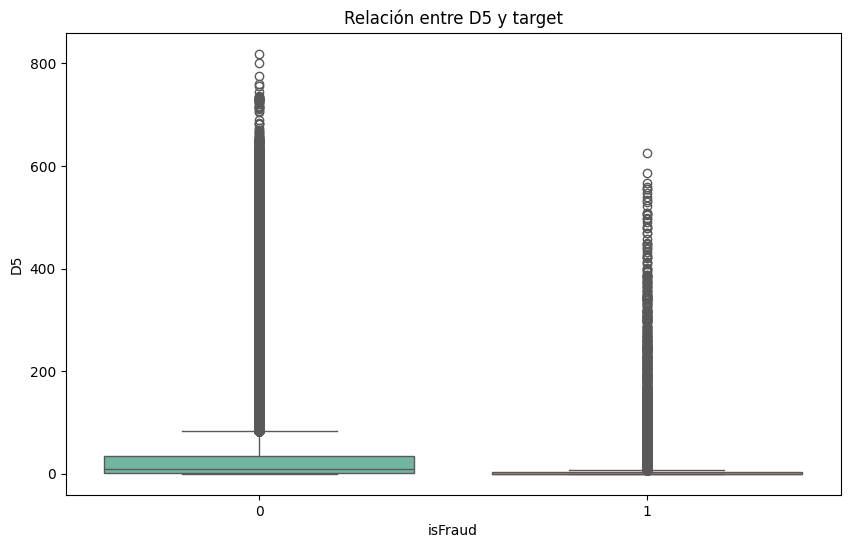

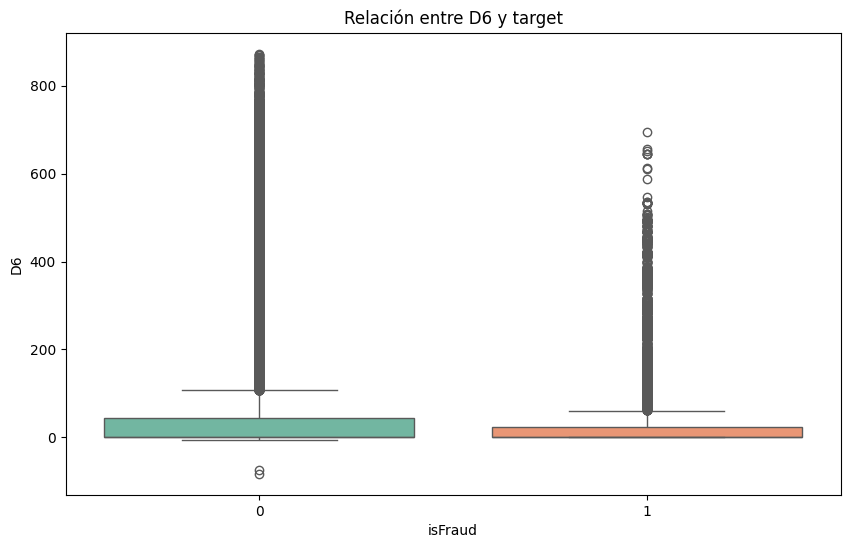

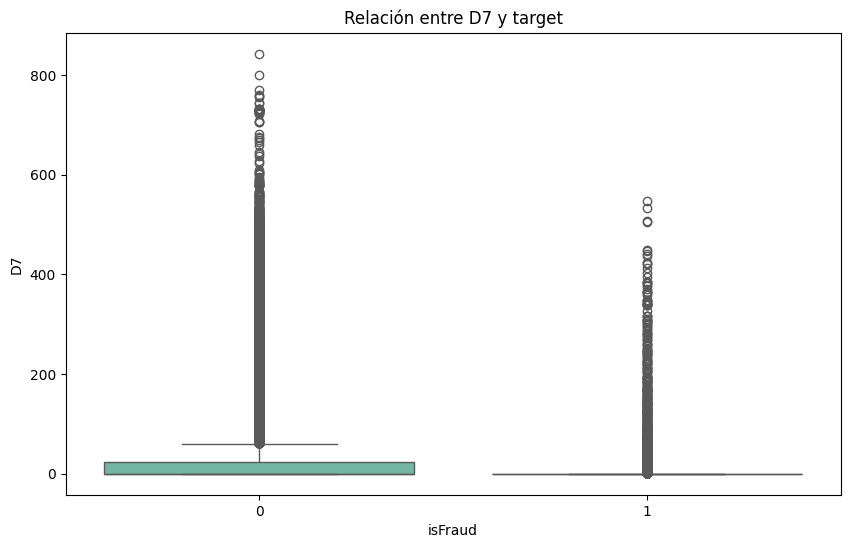

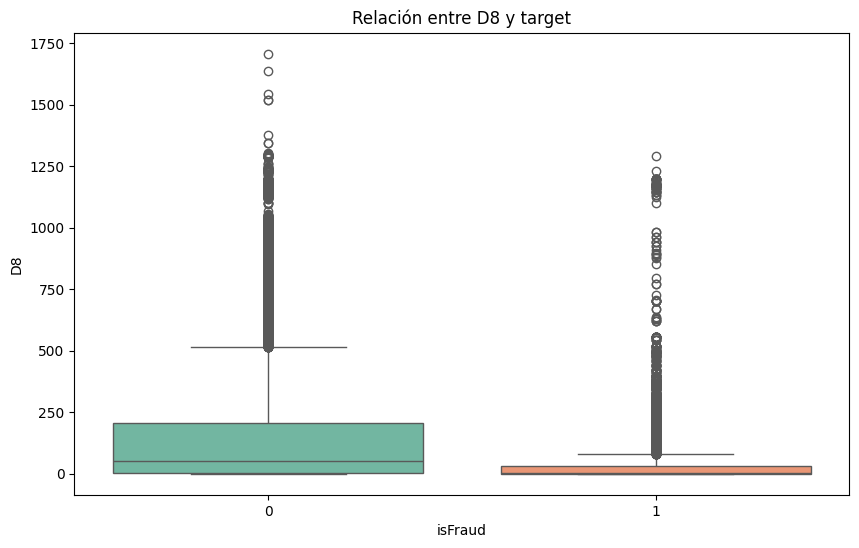

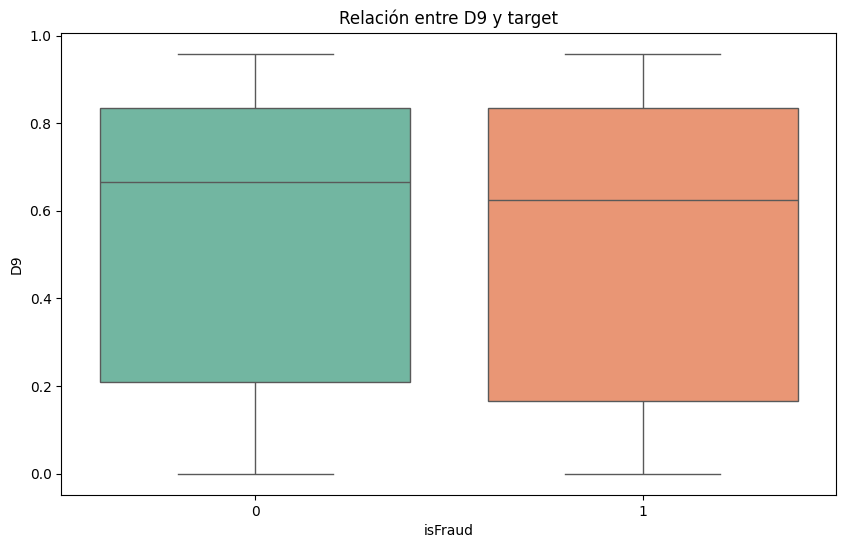

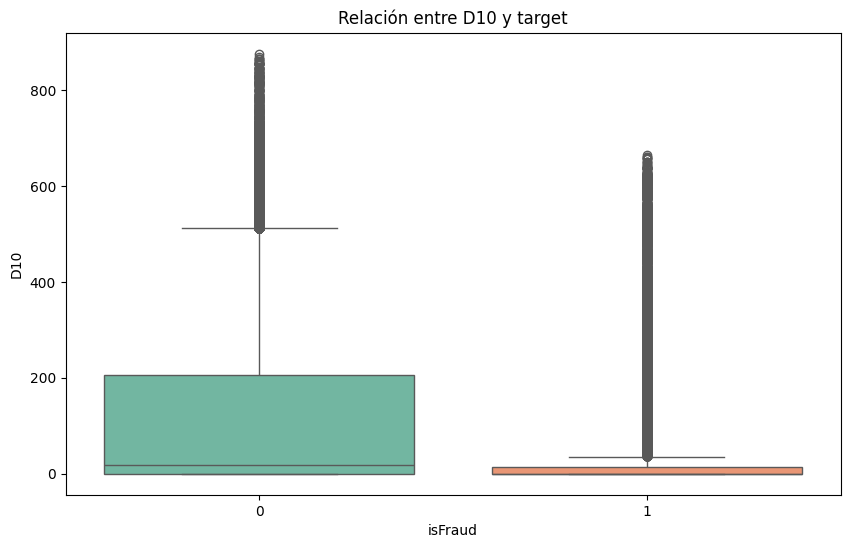

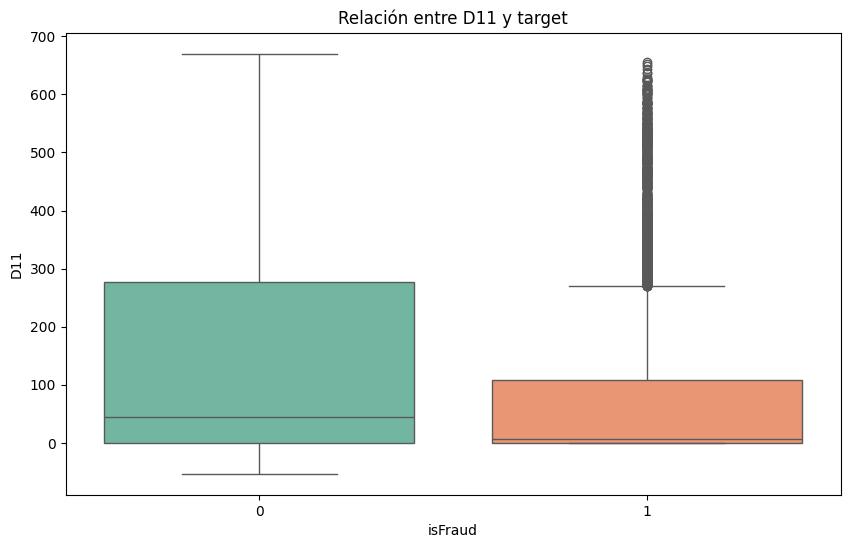

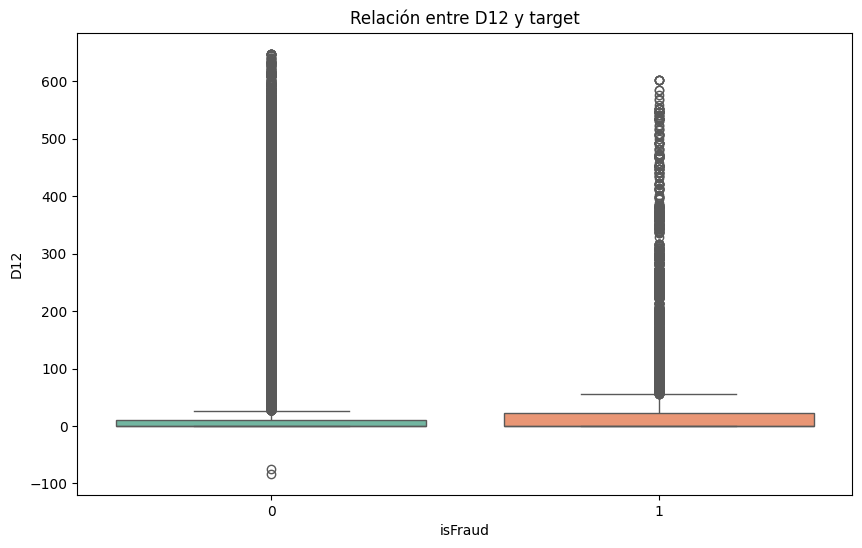

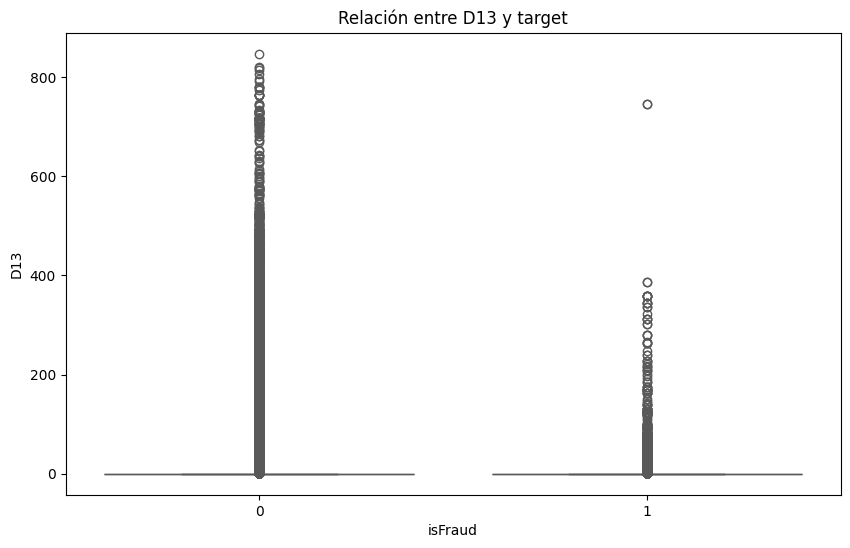

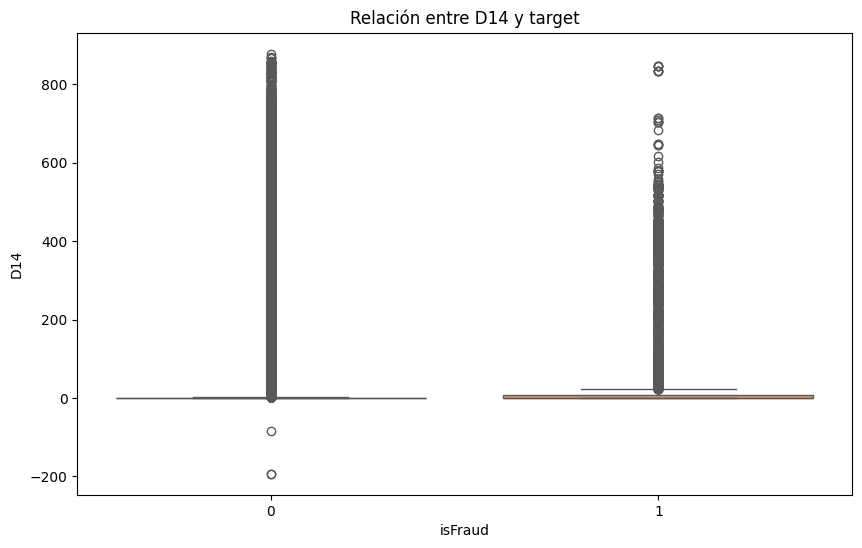

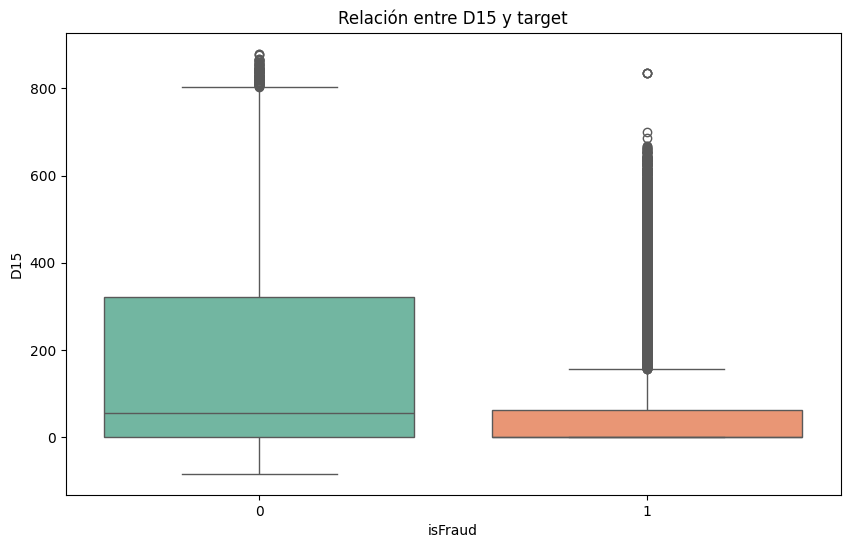

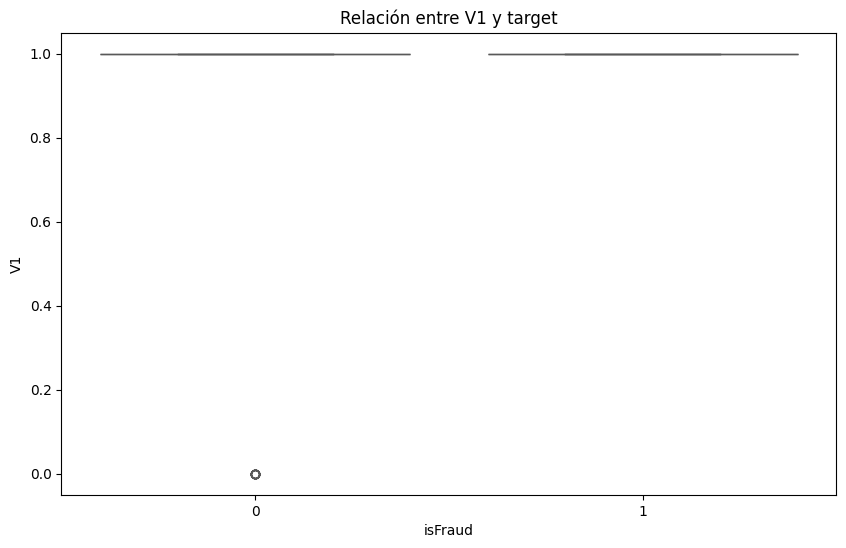

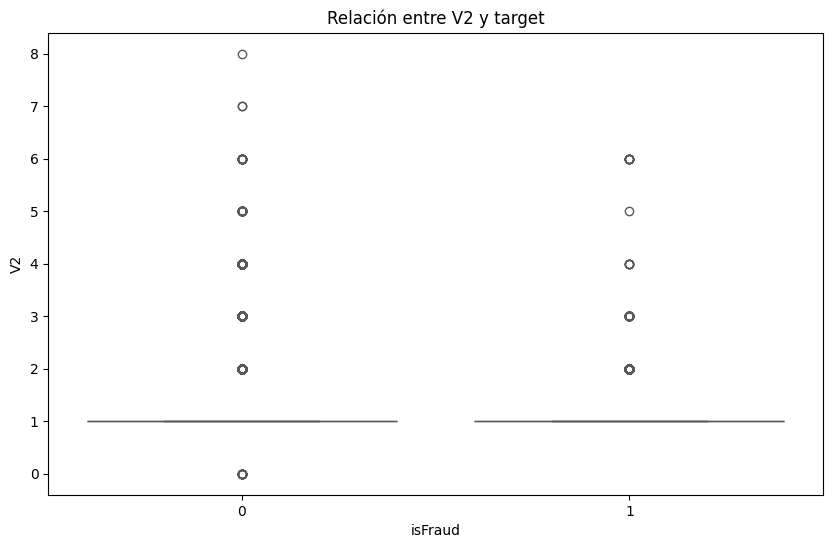

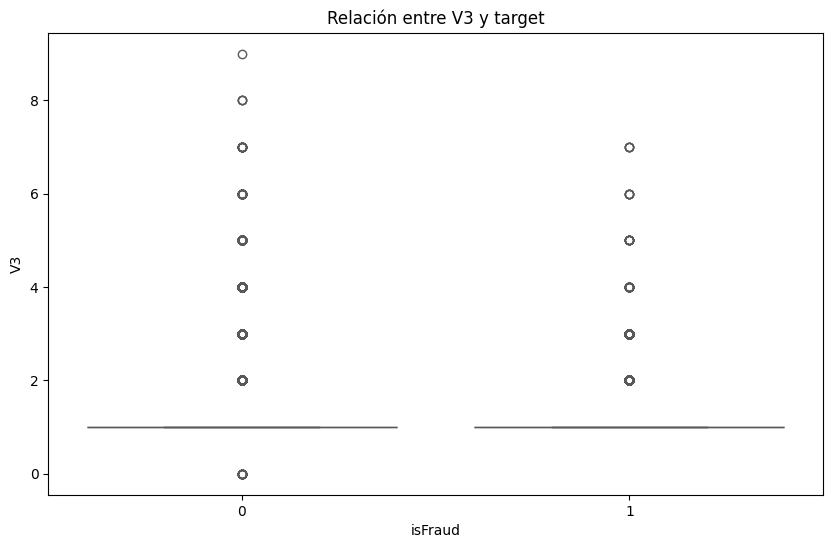

KeyboardInterrupt: 

<Figure size 1000x600 with 0 Axes>

In [127]:
palette = 'Set2'  # Puedes cambiar 'Set2' por otras paletas como 'Set1', 'Set3', 'Dark2', etc.

# Generar los boxplots con la paleta de colores genérica
for column in df_train.select_dtypes(include=['number']).columns:
    if column != 'isFraud':
        plt.figure(figsize=(10, 6))
        sns.boxplot(x='isFraud', y=column, data=df_train, hue='isFraud', palette=palette, legend=False)
        plt.title(f'Relación entre {column} y target')
        plt.show()


**Observaciones:**
Las características numéricas se analizaron en relación con la variable objetivo "isFraud". Se observó lo siguiente:

- TransactionDT: Tanto las transacciones fraudulentas como las no fraudulentas presentan distribuciones similares.
- TransactionAmt: Se observa una mayor diferencia debido a la presencia de valores atípicos y diferentes distribuciones entre los casos con fraude y sin fraude.
- Addr1:Las direcciones por región son similares tanto para los casos con fraude como para los casos sin fraude.
- Add2: Las direcciones por país son similares tanto para los casos con fraude como para los casos sin fraude.
- Card1: Las distribución con fraude y no fraude son similares
- Card2 y Card5: Hay diferencia entre ellas significativas

In [ ]:
df_stat = df_train.groupby('isFraud').describe(include='number').T.round(2)
df_stat['diferencia_absoluta'] = df_stat['No'] - df_stat['Sí']
df_stat['diferencia_relativa %'] = round(abs((df_stat['diferencia_absoluta'] / df_stat.sum(axis=1)) * 100),2)

df_stat.sort_values(by='diferencia_relativa %',ascending=False)

In [ ]:
df_stat.loc[df_stat.index.get_level_values(1) == 'mean'].sort_values(by='diferencia_relativa %',ascending=False)

** Observación**
- Se observa que las diferencias relativas en los valores medios de las características numéricas son menores al 1%, excepto en "TransactionAmt" que es el del 21.69%, lo cual podría deberse a la presencia de valores atípicos y card2 que es del 2.88%,
Esto podŕia indicar una dificultad en el entrenamiento con las características numéricas, ya que sus distribuciones no son muy difrentes


### Características Categóricas

In [ ]:
count_table = pd.crosstab(index=df_train['ProductCD'], columns=df_train['isFraud'])
count_table = count_table.sort_values(by='Sí',ascending=False)
# Configurar el estilo y tamaño del gráfico
plt.figure(figsize=(10, 6))

# Crear el countplot utilizando seaborn
sns.countplot(data=df_train, x='ProductCD', hue='isFraud', palette='Set2')

# Ajustar el formato de las etiquetas del eje x para mejorar la legibilidad
plt.xticks(rotation=0)

# Añadir título y etiquetas de los ejes
plt.title('Countplot de ProductCD desglosado por isFraud')
plt.xlabel('ProductCD')
plt.ylabel('Count')

# Mostrar el gráfico con leyenda
plt.legend(title='isFraud')
plt.tight_layout()
plt.show()

# Mostrar la tabla de conteo desglosada por ProductCD y isFraud
print(count_table)

In [ ]:

top_5_domains = df_train['P_emaildomain'].value_counts().head(5).index
df_top_5 = df_train[df_train['P_emaildomain'].isin(top_5_domains)]
sns.countplot(data=df_top_5, x='P_emaildomain', hue='isFraud')
plt.xticks(rotation=45, ha='right')
plt.title('Countplot de los 5 primeros P_emaildomain separado por isFraud')
plt.xlabel('P_emaildomain')
plt.ylabel('Count')
plt.legend(title='isFraud')
plt.tight_layout()
plt.show()


In [ ]:
count_table = pd.crosstab(index=df_train['P_emaildomain'], columns=df_train['isFraud'])
count_table = count_table.sort_values(by='Sí',ascending=False).head(5)
count_table

In [ ]:

# Crear tabla de contingencia (crosstab) desglosando por P_emaildomain y isFraud
count_table = pd.crosstab(index=df_train['P_emaildomain'], columns=df_train['isFraud'])

# Ordenar la tabla por la cantidad de fraudes (isFraud == 1)
count_table = count_table.sort_values(by='Sí', ascending=False).head(5)

# Calcular el porcentaje en función del total de cada columna
count_table_percentage = count_table.apply(lambda x: x / x.sum() * 100, axis=0).round(2)

# Mostrar la tabla de contingencia y su porcentaje
print("Tabla de Contingencia :")
print(count_table)
print("\nPorcentaje en función del total de cada columna:")
print(count_table_percentage)

In [ ]:

# Crear tabla de contingencia (crosstab) desglosando por ProductCD y isFraud
count_table = pd.crosstab(index=df_train['ProductCD'], columns=df_train['isFraud'])

# Ordenar la tabla por la cantidad de fraudes (isFraud == 1)
count_table = count_table.sort_values(by='Sí', ascending=False)

# Calcular el porcentaje en función del total de cada columna
count_table_percentage = count_table.apply(lambda x: x / x.sum() * 100, axis=0).round(2)

# Mostrar la tabla de contingencia y su porcentaje
print("Tabla de Contingencia :")
print(count_table)
print("\nPorcentaje en función del total de cada columna:")
print(count_table_percentage)

### Cards Categóricas

In [ ]:
df_train[cards].select_dtypes('object')

In [ ]:

sns.countplot(data=df_train, x='card6', hue='isFraud')
plt.xticks(rotation=45, ha='right')
plt.title('Countplot de Card6 Categoría de la tarjeta' )
plt.xlabel('Card6 ')
plt.ylabel('Count')
plt.legend(title='isFraud')
plt.tight_layout()
plt.show()


In [ ]:


sns.countplot(data=df_train, x='card4', hue='isFraud')
plt.xticks(rotation=45, ha='right')
plt.title('Countplot de Card4 Empresa emisora tarjeta' )
plt.xlabel('Card4 ')
plt.ylabel('Count')
plt.legend(title='isFraud')
plt.tight_layout()
plt.show()


In [ ]:


sns.countplot(data=df_train, x='card4', hue='card6')
plt.xticks(rotation=45, ha='right')
plt.title('Countplot de Card4 Empresa emisora tarjeta' )
plt.xlabel('Card4 ')
plt.ylabel('Count')
plt.legend(title='Categoría tarjeta')
plt.tight_layout()
plt.show()


In [ ]:

# Crear tabla de contingencia (crosstab) desglosando por ProductCD y isFraud
count_table = pd.crosstab(index=df_train['card4'], columns=df_train['isFraud'])

# Ordenar la tabla por la cantidad de fraudes (isFraud == 1)
count_table = count_table.sort_values(by='Sí', ascending=False)

# Calcular el porcentaje en función del total de cada columna
count_table_percentage = count_table.apply(lambda x: x / x.sum() * 100, axis=0).round(2)

# Mostrar la tabla de contingencia y su porcentaje
print("Tabla de Contingencia :")
print(count_table)
print("\nPorcentaje en función del total de cada columna:")
print(count_table_percentage)

- La mayoría de los fraude es con 67% con la empresa Visa, seguida por la mastecard con un 29%, seguidas las otras empresas

In [ ]:

# Crear tabla de contingencia (crosstab) desglosando por ProductCD y isFraud
count_table = pd.crosstab(index=df_train['card6'], columns=df_train['isFraud'])

# Ordenar la tabla por la cantidad de fraudes (isFraud == 1)
count_table = count_table.sort_values(by='Sí', ascending=False)

# Calcular el porcentaje en función del total de cada columna
count_table_percentage = count_table.apply(lambda x: x / x.sum() * 100, axis=0).round(2)

# Mostrar la tabla de contingencia y su porcentaje
print("Tabla de Contingencia :")
print(count_table)
print("\nPorcentaje en función del total de cada columna:")
print(count_table_percentage)

- Los valores de fraude con debito es de 57.6% y con credito de 42%, la diferencia es de un 15%, podría ser significativo.

**Observación**
- ProductCD: El producto con el mayor porcentaje de fraude es "W", representando el 66.8 % del total de productos con fraude. Le sigue el producto "H" con un 15.19 %, luego "R" con un 14.7 %, y en menor medida el producto "C" con solo un 3.31 %.
- El correo con mayor incidencia de fraude es el de Gmail, alcanzando un 57.96 % del total. Le sigue Yahoo con un 25.33 %, mientras que los demás proveedores de correo tienen una incidencia menor. Es probable que el alto porcentaje de fraudes en cuentas de Gmail se deba a su amplia base de usuario.

### Correlción entre las variables numéricas

In [ ]:
df_train['isFraud'] = df_train['isFraud'].replace({'No': 0, 'Sí': 1})

In [ ]:
correlation_matrix = df_train.select_dtypes(exclude=['object']).corr()

# Filtrar para obtener solo las correlaciones con la columna 'isfraud'
isfraud_correlation = correlation_matrix[['isFraud']].sort_values(by='isFraud', ascending=False)

# Visualización de las correlaciones con 'isfraud'
plt.figure(figsize=(10, 8))
sns.heatmap(isfraud_correlation, annot=True, cmap='coolwarm', fmt=".2f", cbar=False)
plt.title('Correlaciones con isFraud')
plt.show()

**Observación**
- Se pude gráfica de correlación entre las variables numéricas se conclute que en general las variables no estan correlacionadas

Generamos un archivo csv con Dataframe de los datos de entrenamiento, el que se usara para la segunda parte del proyecto, "Limpieza y preprocesamiento de los datos"

In [ ]:
dir_data_interim = '../data/interim/'
ruta_archivo_completa = os.path.join(dir_data_interim, 'train')

df_train.to_csv(ruta_archivo_completa, index=False, encoding='utf-8')

### Conclusiones

Durante el análisis exploratorio de datos, se realizaron varias observaciones significativas sobre el dataset:

- El dataset original contiene más de medio millón de registros, por lo que se aplicó un método de muestreo estratificado para obtener una muestra representativa y manejable.
- Se seleccionaron las características más relevantes para el objetivo de detección de fraude en este primer análisis.
- Se identificaron columnas con valores nulos, se evaluó su cantidad y porcentaje, así como la correlación entre ellas. Se decidió eliminar aquellas columnas con un alto porcentaje de valores nulos para simplificar el análisis.
- Se encontraron y eliminaron valores duplicados, que eran escasos en comparación con el tamaño total del dataset.
- Del análisis univariado:
  - La columna objetivo "isFraud" muestra un desbalance con un 97.6% de registros no fraudulentos, lo cual debe considerarse al entrenar cualquier modelo.
  - La columna "TransactionAmt", que representa los montos de transacción, presenta distribuciones distintas según los rangos de valores y algunos valores atípicos, sugiriendo la segmentación para el entrenamiento del modelo.
  - La columna "TransactionDT" muestra una distribución uniforme en los datos.
  - La columna "ProductCD", que indica el producto de la transacción, muestra que casi el 82.71% de las transacciones corresponden al producto "W", seguido por "R" con 8.75%, "H" con 7.76%, y "C" con 0.78%.
  - La columna "addr1", que representa la dirección por región de los compradores, muestra que el 9.48% de las transacciones provienen de la región "299", seguida por "204", "325", "264" y otras regiones con menor porcentaje.
  - La columna "addr2", que representa la dirección por país, indica que el país con más transacciones tiene el código "84", representando el 99% del total de transacciones en el dataset.
  - La columna "P_emaildomain", que representa los proveedores de correo electrónico de los compradores, muestra que Gmail tiene la mayor incidencia de fraude con un 57.96% del total, seguido por Yahoo con un 25.33%. Otros proveedores tienen una incidencia menor de fraude.

- Del análisis bivariado:
  - TransactionDT: Tanto las transacciones fraudulentas como las no fraudulentas presentan distribuciones similares.
  - TransactionAmt: Se observa una mayor diferencia debido a la presencia de valores atípicos y diferentes distribuciones entre los casos con fraude y sin fraude.
  - Addr1:Las direcciones por región son similares tanto para los casos con fraude como para los casos sin fraude.
  - Add2: Las direcciones por país son similares tanto para los casos con fraude como para los casos sin fraude.
  - Se observa que las diferencias relativas entre si es fraude o no en los valores medios de las características numéricas son menores al 1%, excepto en "TransactionAmt", lo cual podría deberse a la presencia de valores atípicos.
Esto podŕia indicar una dificultad en el entrenamiento con las características numéricas, ya que sus distribuciones no son muy difrentes
  - ProductCD: El producto con el mayor porcentaje de fraude es "W", representando el 66.8 % del total de productos con fraude. Le sigue el producto "H" con un 15.19 %, luego "R" con un 14.7 %, y en menor medida el producto "C" con solo un 3.31 %.
  - El correo con mayor incidencia de fraude es el de Gmail, alcanzando un 57.96 % del total. Le sigue Yahoo con un 25.33 %, mientras que los demás proveedores de correo tienen una incidencia menor. Es probable que el alto porcentaje de fraudes en cuentas de Gmail se deba a su amplia base de usuario.

  

Estas conclusiones proporcionan una base sólida para entender la distribución de los datos y guiarán el preprocesamiento adicional y la construcción de modelos en futuros análisis.
